### README

#### Overview
../HillModel/Figures.ipynb plots part of the figures from the paper: 
Mijatović, T., Kok, A. R., Zwanikken, J. W., & Bauer, M. (2025). Weak transcription factor clustering at binding sites can facilitate information transfer from molecular signals. arXiv preprint [arXiv:2505.07641](https://arxiv.org/abs/2505.07641).

It specfically plots the figures related to the experiment data (Figure 1) and the Hill model (Figure 2) and the information bottleneck (Figure 4, except 4A), as well as Figures 5, 6 and 8 from the supplement. 

All experiment data was used with permission of the authors. Note that the experiment data for Figure 1B and 1C is not available in the GitHub repository. Please contact that authors of the data source if you are interested in the data.

#### Usage
- To reconstruct all the paper figures, simply run the script! 
- If you want to reconstruct a single figure, first run the library import code, then run the specific figure code. 
- If you want to change the data used for a specific figure, you can change the data directory in each separate figure code by changing `datadir = ...` (when applicable).

#### User notes
- The notebook uses data stored in `../HillModel/Data/`
    - The `ExperimentData/` is stored in formats: `.mat`and `.npy`.
    - The `ModelData/`, generated using `HillModel.py`, is stored as tabular `.csv` files and the corresponding parameters are stored as a `.json` file. 
        - The directory name also contains part of the parameters to make it easily recognizable. 
- The code assumes you are running from the `../HillModel/Code/` directory. 
- Generated (and used) figures are stored in `../HillModel/Figures/`
- Be aware that a lot of the figure styling is hard-coded to make it paper-ready, so running the figures with different data might might look weird with the current axis limits, tick labels, placement of colorbars etc. 

#### Glossary
- $h$   - Hill/cooperativity coefficient \[-\]
- $k$   - dissociation equilibrium constant, defined as $k = k_{off}/k_{on}$ \[-\]
- $k_{\text{on}}$ - association rate of transcription factors \[$\text{s}^{-1}$\]
- $k_{\text{off}}$ - dissociation rate of transcription factors \[$\text{s}^{-1}$\]
- $\tau$ - averaging/measurement time [$\text{s}$]
- $C$ - normalized mean occupation of the binding device \[-\]
- $s$ - normalized Bicoid concentration \[-\]
- $x$ - normalized embryo position \[-\]


### RUN THIS FIRST!
- Imports all relevant libraries
- Defines helper functions
- Defines new colormaps

In [ ]:
### IMPORT LIBRARIES
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import numpy as np 
import pandas as pd 
import scipy.io 
import os
import json 
from IPython.display import Image, display

### HELPER FUNCTIONS
def get_colorbar_ticks(data):
    # Returns a list of rounded ticks at 10%, 50% and 90% of the color bar
    min_data = data.min()
    max_data = data.max()
    cbar_tick010 = np.round(min_data + (max_data - min_data) * 0.1, 1)
    cbar_tick050 = np.round(min_data + (max_data - min_data) * 0.5, 1)
    cbar_tick090 = np.round(min_data + (max_data - min_data) * 0.9, 1)
    return [cbar_tick010, cbar_tick050, cbar_tick090]

def hill_function(S, h, k):
    return S**h / (S**h + k + 1e-50)

def calculate_mean_and_variance(h, k, Ss, tau, mode='koff', koff=1, kon=1, n=1):
    # Calculate mean and variance for the compressed gene expression from our Hill function model.
    # See Appendix A of the paper for the derivation of the variance.
    # 'mode' sets the type of calculation for the Hill model we want to use
    #   - 'koff': sets koff as constant, with a variable kon defined by k
    #   - 'kon': sets kon as constant, with a variable koff defined by k 
    #   - 'non-coop': a check for a non-cooperative binding devices
    #                 here, h sets the number of non-cooperative binding sites
    #                 n should be kept as 1 for full non-cooperativtity

    # Version with koff constant
    if mode == 'koff':
        Cmeans = hill_function(Ss, h, k)
        Cvars = (2./(tau*koff)) * ((Ss**h)/(Ss**h + k)) * (k /(Ss**h +k))**2

    # Version with kon constant
    elif mode == 'kon':
        Cmeans = hill_function(Ss, h, k)
        Cvars = (2./(tau*kon)) * (k*(Ss**h)) / ((k+Ss**h)**3)

    # Version with non-cooperative binding devices (for comparison)
    # Assumes constant koff as well 
    elif mode == 'non-coop':
        Cmeans = hill_function(Ss, n, k)
        Cvars = (2./(tau*h*koff)) * ((Ss**n)/(Ss**n + k)) * (k /(Ss**n +k))**2
        
    else:
        print("No valid mode for calculating the mean and variance of C was chosen.")
    return Cmeans, Cvars

### NEW COLORMAPS
new_oranges = LinearSegmentedColormap.from_list("flow_orange", ["#fdb74f", "#953f07"])
new_blues = LinearSegmentedColormap.from_list("flow_blue", ["#5fb0e1", "#040a1d"])
new_blacks = LinearSegmentedColormap.from_list("flow_black", ['k', "#cccccc"])

### Figure 1A
- Plots the normalized Bicoid gradient along the normalized embryonal axis. 
- Uses data file: `TG_normBcd.mat`
- Data source: T. Gregor, D. W. Tank, E. F. Wieschaus, and W. Bialek, *Cell* 130, 153 (2007).

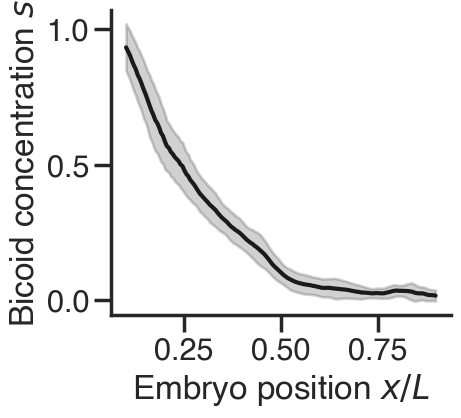

In [2]:
### FIGURE 1A: Bicoid concentration gradient 

### FIGURE SETTINGS
sns.set_theme(context='poster', style='ticks', palette='deep', font='Helvetica', font_scale=1)

### IMPORT DATA
file = '../Data/ExperimentData/TG_normBcd.mat'
Bcd  = scipy.io.loadmat(file)['TGB_norm1']

meanBcd = np.mean(Bcd, axis=0)
stdBcd  = np.std(Bcd, axis=0)
x       = np.linspace(0.,1,len(meanBcd)) 
mask    = np.where(np.logical_and(x>=0.1, x<=0.9))

### PLOT FIGURE
fig, ax = plt.subplots(1, 1, figsize=(5.3,4.7))
ax.fill_between(x[mask], meanBcd[mask] - stdBcd[mask], meanBcd[mask] + stdBcd[mask], color='k', alpha=0.2)
ax.plot(x[mask], meanBcd[mask], color='k', label='Bicoid')
ax.set_xlabel(r'Embryo position $x/L$')
ax.set_ylabel(r'Bicoid concentration $s$')
ax.spines[['right', 'top']].set_visible(False) 
fig.tight_layout()
fig.savefig('../Figures/Figure1A.pdf')

### Figure 1B
- Plots the normalized Gap protein concentrations as a function of normalized embryo position
- Uses data files: 
    - `GapProteins_means.npy`
    - `GapProteins_sigmas.npy`
- Note: these files are not available in the GitHub repository.
- Data source: M. D. Petkova, G. Tkačik, W. Bialek, E. F. Wieschaus, and T. Gregor, *Cell* 176, 844 (2019)

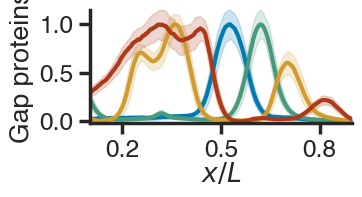

In [3]:
### FIGURE 1B: Gap proteins 

### FIGURE SETTINGS
sns.set_theme(context='poster', style='ticks', palette='deep', font='Helvetica', font_scale=0.8)

# Check if file exists
try:
    ### IMPORT DATA
    meanGps = np.load('../Data/ExperimentData/GapProteins_means.npy')
    stdGps  = np.load('../Data/ExperimentData/GapProteins_sigmas.npy')
    x       = np.linspace(0.1, 0.9, meanGps.shape[1]) # normalized embryo position 
    genes   = ['Kr', 'Kni', 'Gt', 'Hb']
    colors  = ['#027ab0', '#49997c', '#d19c2f', '#ae3918']

    ### PLOT FIGURE
    fig, ax = plt.subplots(1, 1, figsize=(4, 2.35))
    for i in range(len(genes)):
        ax.fill_between(x, meanGps[0, :, i]-stdGps[0, :, i], meanGps[0, :, i]+stdGps[0, :, i], lw=1, color=colors[i], alpha=0.2)
        ax.plot(x, meanGps[0, :, i], lw=3, color=colors[i], label=genes[i])
    ax.set_xlabel('$x/L$', labelpad=-0.3)
    ax.set_ylabel('Gap proteins')
    ax.set_xticks([0.2, 0.5, 0.8])
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_ylim([-0.02, 1.15])
    ax.set_xlim([0.1, 0.9])
    ax.tick_params(length=8)
    ax.spines[['right', 'top']].set_visible(False) 
    fig.tight_layout()
    fig.savefig('../Figures/Figure1B.pdf', bbox_inches='tight', pad_inches=0.3) 
except:
    print("Data file not found. Will plot ../Figures/Figure1B.pdf.")
    display(Image(filename='../Figures/Figure1B.png',  width=300) )


### Figure 1C
- Plots *hb* mRNA output
- Uses file: `hbRNA_data.mat`
- Note: these files are not available in the GitHub repository.
- Data source: S. C. Little, M. Tikhonov, and T. Gregor, *Cell* 154, 789 (2013).


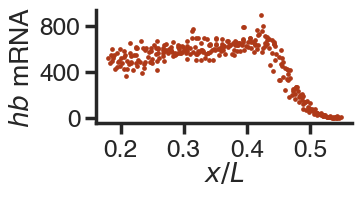

In [4]:
### FIGURE 1C: hb mRNA 

### FIGURE SETTINGS
sns.set_theme(context='poster', style='ticks', palette='deep', font='Helvetica', font_scale=0.8)

try:
    ### IMPORT DATA
    data   = scipy.io.loadmat('../Data/ExperimentData/hbRNA_data.mat')
    hbmRNA = data['allY'][0][3][0]
    x      = data['allX'][0][3][0] 

    ### PLOT FIGURE
    fig, ax = plt.subplots(1, 1, figsize=(4, 2.35))
    ax.scatter(x, hbmRNA, s=2, c='#ae3918', label='Hb')
    ax.set_xlabel('$x/L$', labelpad=-0.3)
    ax.set_ylabel('$hb$ mRNA')
    ax.tick_params(length=8)
    ax.set_yticks([0, 400, 800])
    ax.set_xticks([0.2, 0.3, 0.4, 0.5])
    ax.spines[['right', 'top']].set_visible(False)
    fig.tight_layout()
    fig.savefig('../Figures/Figure1C.pdf', bbox_inches='tight')
except:
    print("Data file not found. Will plot ../Figures/Figure1C.pdf.")
    display(Image(filename='../Figures/Figure1C.png',  width=300) )

### Figure 2A:
- Binding site device schematic

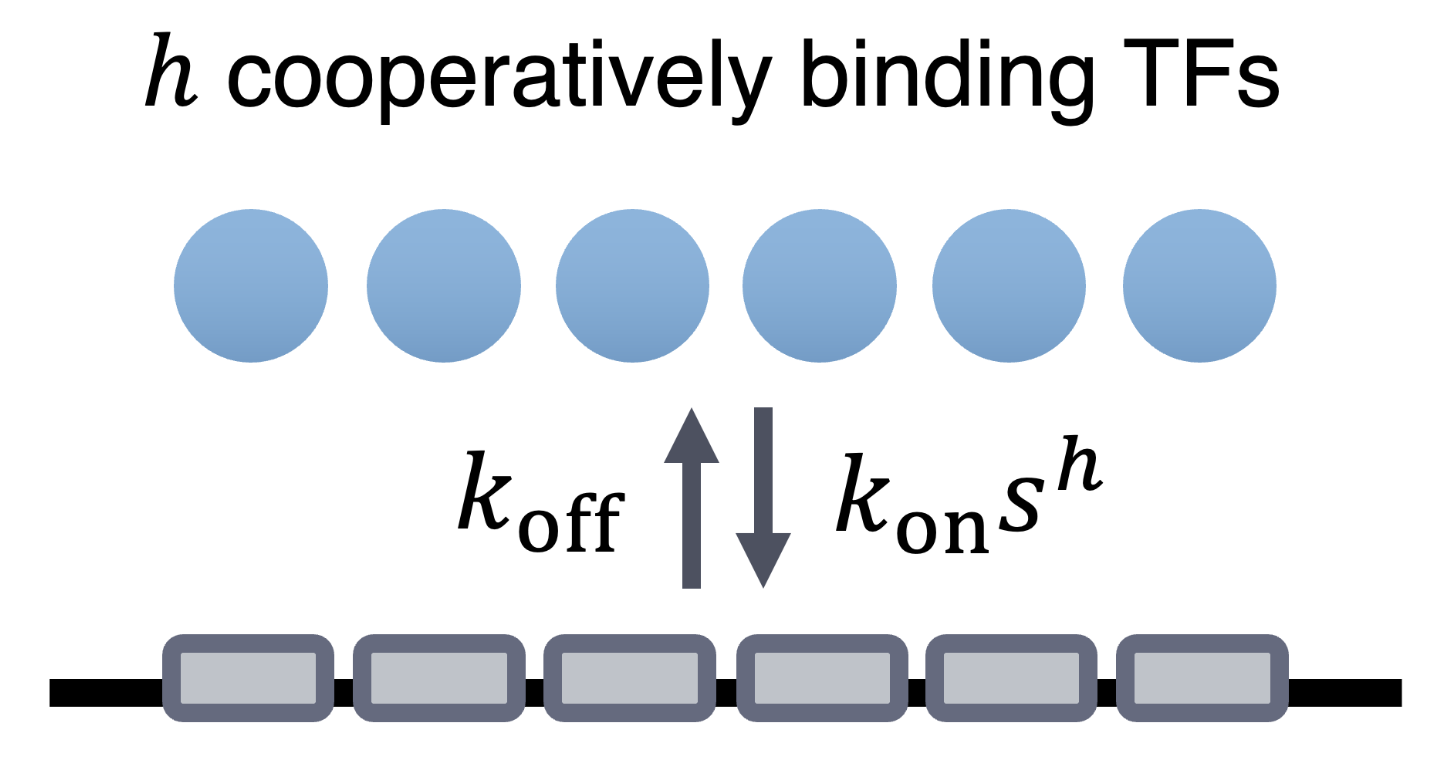

In [5]:
### FIGURE 2A: Binding site device schematic
Image(filename='../Figures/Figure2A.png',  width=300) 

### Figure 2B: 
- Plots example binding site devices, $P(C|s)$

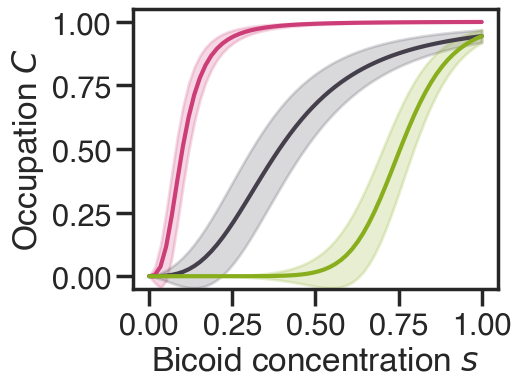

In [6]:
### FIGURE 2B: Example binding site devices

### FIGURE SETTINGS
sns.set_theme(context='poster', style='ticks', palette='deep', font='Helvetica', font_scale=1.0)

# Set options for the binding devices
Ss      = np.linspace(0,1,60)
hs      = [3, 3, 10]
ks      = [0.001, 0.06, 0.06]
taus    = [10, 10, 10]
mode    = 'koff'
koff    = 1
colors  = ['#CD3E78', '#443F4B', '#88AE1D']

### PLOT FIGURE
fig, ax = plt.subplots(1, 1, figsize=(5.7, 4.4))
for i in range(len(hs)):
    Cmeans, Cvars = calculate_mean_and_variance(hs[i], ks[i], Ss, taus[i], mode=mode, koff=koff)
    ax.fill_between(Ss, Cmeans - np.sqrt(Cvars), Cmeans + np.sqrt(Cvars), color=colors[i], alpha=0.2)
    ax.plot(Ss, Cmeans, color=colors[i])
ax.set_xlabel(r'Bicoid concentration $s$')
ax.set_ylabel(r'Occupation $C$')
ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_ylim([-0.05, 1.05])
fig.tight_layout()
fig.savefig('../Figures/Figure2B.pdf')

### Figure 2C: 
- Plots mutual information in the $h$,$k$-plane
- Paper figure uses data from: `hillmode-koff_tau10-600_h1-20_k3E-05-1E+00_kon1_koff1_n1_Sbins60_Cbins100_Ccov0.60`


I(C;x) max = 1.53 bits at h = 4.82 and k = 1.26E-03
I(C;s) max = 2.21 bits at h = 3.58 and k = 8.39E-04


/var/folders/rj/_5k7bwfs4f78f6vm4cy0cky9258p8x/T/ipykernel_8996/2437118168.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


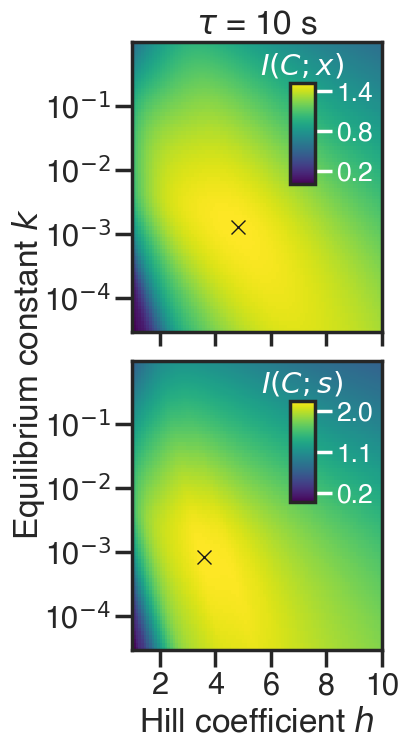

In [7]:
# FIGURE 2C: Mutual information in the h,k-plane 

### FIGURE SETTINGS
sns.set_theme(context='poster', style='ticks', palette='deep', font='Helvetica', font_scale=1.0)
tau = 10            # which tau to plot
plot_maximum = True # if True plot max MI as 'x' in h,k plane

### IMPORT DATA
datadir = "hillmode-koff_tau10-600_h1-20_k3E-05-1E+00_kon1_koff1_n1_Sbins60_Cbins100_Ccov0.60"
loadpath = f"../Data/ModelData/{datadir}"

# Import parameters
with open(f"{loadpath}/parameters.json", "r") as file:
    parameters = json.load(file)
taus, hs, ks = parameters['taus'], parameters['hs'], parameters['ks']
tau_idx = taus.index(tau)

# Import the data
MI_all_df = pd.read_csv(f"{loadpath}/MIs_all.csv")
I_CX_test = np.reshape(MI_all_df['I_CX'],(len(hs), len(ks), len(taus)))
I_CS_test = np.reshape(MI_all_df['I_CS'],(len(hs), len(ks), len(taus)))


### PLOT FIGURE
fig, axs = plt.subplots(2, 1, figsize=(5, 8), sharex=True, sharey=True)

# Plot I(C;x)
c1 = axs[0].pcolor(hs, np.log10(ks), I_CX_test[:, :, tau_idx].T, cmap='viridis')
axs[0].set_title(r'$\tau$' + f' = {taus[tau_idx]} s')
axs[0].tick_params(axis='both', which='major')
axs[0].set_yticks([-1, -2, -3, -4])
axs[0].set_yticklabels(['10$^{-1}$', '10$^{-2}$', '10$^{-3}$', '10$^{-4}$'])
axs[0].tick_params(axis='x', which='major',
                    bottom=True, top=False, length=10)

# Plot I(C;s)
c2 = axs[1].pcolor(hs, np.log10(ks), I_CS_test[:, :, tau_idx].T, cmap='viridis')
axs[1].set_xlabel(r'Hill coefficient $h$')
axs[1].tick_params(axis='both', which='major')
axs[1].set_xlim([1, 10])
axs[1].set_xticks([2, 4, 6, 8, 10])
# axs[1].set_xticks([5, 10, 15, 20])

# Plot the h,k of maximum MI as 'x'
if plot_maximum:
    max_IC_X_idx = np.where(I_CX_test[:, :, tau_idx] == I_CX_test[:, :, tau_idx].max())
    h_at_max, k_at_max = hs[max_IC_X_idx[0][0]], ks[max_IC_X_idx[1][0]]
    axs[0].plot(h_at_max, np.log10(k_at_max),'x', color='k', markersize=10)
    print( f'I(C;x) max = {I_CX_test[:, :, tau_idx].max():.2f} bits at h = {h_at_max:.2f} and k = {k_at_max:.2E}')

    max_IC_S_idx = np.where(I_CS_test[:, :, tau_idx] == I_CS_test[:, :, tau_idx].max())
    h_at_max, k_at_max = hs[max_IC_S_idx[0][0]], ks[max_IC_S_idx[1][0]]
    axs[1].plot(h_at_max, np.log10(k_at_max),'x', color='k', markersize=10)
    print(f'I(C;s) max = {I_CS_test[:, :, tau_idx].max():.2f} bits at h = {h_at_max:.2f} and k = {k_at_max:.2E}')

# Colorbar for I(C;x) row
cax1 = inset_axes(axs[0], width="10%", height="35%", loc='lower right',
                    bbox_to_anchor=(-0.27, 0.51, 1, 1), bbox_transform=axs[0].transAxes, borderpad=0)
cbar1 = fig.colorbar(c1, cax=cax1)
cbar1.set_ticks(get_colorbar_ticks(I_CX_test[:, :, tau_idx]))
cbar1.ax.yaxis.set_tick_params(color='white', labelsize=19)
cbar1.ax.set_title(r'$I(C;x)$', color='white', fontsize=21)
plt.setp(plt.getp(cbar1.ax.axes, 'yticklabels'), color='white')

# Colorbar for I(C;s) row
cax2 = inset_axes(axs[1], width="10%", height="35%", loc='lower right',
                    bbox_to_anchor=(-0.27, 0.51, 1, 1), bbox_transform=axs[1].transAxes, borderpad=0)
cbar2 = fig.colorbar(c2, cax=cax2)
cbar2.set_ticks(get_colorbar_ticks(I_CS_test[:, :, tau_idx]))
cbar2.ax.yaxis.set_tick_params(color='white', labelsize=19)
cbar2.ax.set_title(r'$I(C;s)$', color='white', fontsize=21)
plt.setp(plt.getp(cbar2.ax.axes, 'yticklabels'), color='white')

# Set shared y-axis label 
fig.supylabel(r'Equilibrium constant $k$', x=0.15, fontsize=24)

# Set final adjustments
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0.1)

# Save figure
plt.savefig(f'../Figures/Figure2C.png', dpi=300)


### Figure 2D: 
- Plots plot maximum $I(C;x)$ vs h and maximum $I(C;s)$ vs h 
- Paper figure uses data from: `hillmode-koff_tau10-600_h1-20_k1E-10-5E+00_kon1_koff1_n1_Sbins60_Cbins100_Ccov0.60`

For t = 10 s: I(C;x) maximum = 1.53 bits at h = 4.63, I(C;s) maximum = 2.21 bits at h = 3.67
For t = 600 s: I(C;x) maximum = 1.78 bits at h = 2.15, I(C;s) maximum = 4.07 bits at h = 2.05


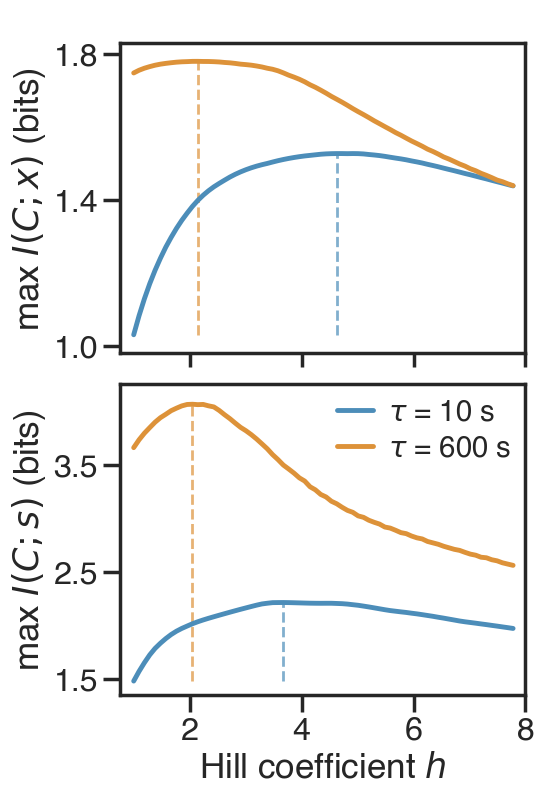

In [ ]:
### FIGURE 2D: Maximum I(C;x) vs h and maximum I(C;s) vs h 

### FIGURE SETTINGS 
sns.set_theme(context='poster', style='ticks', palette='deep', font='Helvetica', 
              font_scale=1.05, color_codes=True, rc=None)
h_lim = 7.9 # Cut-off the data at this h value for 
remove_k_boundary = True # Whether or not to include MI values that lie on the k boundary

### IMPORT DATA
datadir = "hillmode-koff_tau10-600_h1-20_k1E-10-5E+00_kon1_koff1_n1_Sbins60_Cbins100_Ccov0.60"
loadpath = f"../Data/ModelData/{datadir}"

# Import parameters
with open(f"{loadpath}/parameters.json", "r") as file:
    parameters = json.load(file)
taus, hs, ks = parameters['taus'], parameters['hs'], parameters['ks']
h_lim_idx = (np.abs(np.array(hs) - h_lim)).argmin()

# Import the relevant data
MI_optimalh_df  = pd.read_csv(f"{loadpath}/MIs_optimal_h.csv")
optimalh_I_CXs  = np.reshape(MI_optimalh_df['optimalh_I_CX'], (len(hs), len(taus)))[:h_lim_idx, :]
optimalh_I_CSs  = np.reshape(MI_optimalh_df['optimalh_I_CS'], (len(hs), len(taus)))[:h_lim_idx, :]
optimalh_ks_ICX = np.reshape(MI_optimalh_df['optimalh_k_ICX'], (len(hs), len(taus)))[:h_lim_idx, :]
optimalh_ks_ICS = np.reshape(MI_optimalh_df['optimalh_k_ICS'], (len(hs), len(taus)))[:h_lim_idx, :]
hs_plot = hs[:h_lim_idx]

# Optional: set values that hit k-boundary to 0 since they might not be representative
if remove_k_boundary:
    for tau_idx in range(len(taus)):
        optimalh_I_CXs[optimalh_ks_ICX[:, tau_idx] <= ks[1]] = 0 
        optimalh_I_CSs[optimalh_ks_ICS[:, tau_idx] <= ks[1]] = 0

### PLOT
fig, axs = plt.subplots(2,1,figsize=(6,8.5), sharex=True)

# Plot maximum I(C;x) vs h 
ymin = 0.98
ymax = 1.83 
axs[0].axvline(hs_plot[np.argmax(optimalh_I_CXs[:,-1])], (np.min(optimalh_I_CXs[:,0]) - ymin) / (ymax - ymin), (np.max(optimalh_I_CXs[:,-1]) - ymin) / (ymax - ymin), linestyle='--', c='#DD9239', linewidth=2, alpha=0.7)
axs[0].axvline(hs_plot[np.argmax(optimalh_I_CXs[:,0])], (np.min(optimalh_I_CXs[:,0]) - ymin) / (ymax - ymin), (np.max(optimalh_I_CXs[:,0]) - ymin) / (ymax - ymin), linestyle='--', c='#4C8DB9', linewidth=2,alpha=0.7)
axs[0].plot(hs_plot, optimalh_I_CXs[:, 0], '-', color='#4C8DB9', markersize=5, label=r'$\tau$'+f' = {taus[0]} s', linewidth=3.5)
axs[0].plot(hs_plot, optimalh_I_CXs[:, -1], '-', color='#DD9239', markersize=5, label=r'$\tau$'+f' = {taus[-1]} s', linewidth=3.5)
axs[0].set_ylabel(r'max $I(C;x)$ (bits)')
axs[0].tick_params(axis='x', which='major', bottom=True, top=False, length=10)
# axs[0].legend(loc='lower right', frameon=False, borderpad=0, handletextpad=0.5, handlelength=1.25, labelspacing=0.3, fontsize=22)
axs[0].set_title(' ')
axs[0].set_ylim([ymin, ymax])
axs[0].set_yticks([1., 1.4, 1.8])
axs[0].set_xticks([2, 4, 6, 8])
axs[0].set_xlim([0.75, h_lim+0.1])

# Plot maximum I(C;s) vs h 
ymin = 1.35
ymax = 4.25
axs[1].axvline(hs_plot[np.argmax(optimalh_I_CSs[:,-1])], (np.min(optimalh_I_CSs[:,0]) - ymin) / (ymax - ymin), (np.max(optimalh_I_CSs[:,-1]) - ymin) / (ymax - ymin), linestyle='--', c='#DD9239', linewidth=2, alpha=0.7)
axs[1].axvline(hs_plot[np.argmax(optimalh_I_CSs[:,0])], (np.min(optimalh_I_CSs[:,0]) - ymin) / (ymax - ymin), (np.max(optimalh_I_CSs[:,0]) - ymin) / (ymax - ymin), linestyle='--', c='#4C8DB9', linewidth=2,alpha=0.7)
axs[1].plot(hs_plot, optimalh_I_CSs[:, 0], '-', color='#4C8DB9', markersize=5, label=r'$\tau$'+f' = {taus[0]} s', linewidth=3.5)
axs[1].plot(hs_plot, optimalh_I_CSs[:, -1], '-', color='#DD9239', markersize=5, label=r'$\tau$'+f' = {taus[1]} s', linewidth=3.5)
axs[1].set_ylim([ymin, ymax])
axs[1].set_yticks([1.5, 2.5, 3.5])
axs[1].legend(loc='upper right', frameon=False, borderpad=0, handletextpad=0.5, handlelength=1.25, labelspacing=0.3, fontsize=21)
axs[1].set_xlabel(r'Hill coefficient $h$') # alternatively: (r"# binding sites $h'$") for non-cooperative
axs[1].set_ylabel(r'max $I(C;s)$ (bits)')

#  Set final figure stuff 
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0.1) 

# Save the figure 
plt.savefig(f'../Figures/Figure2D.pdf')

# Print out the top of the maximum MI values and the corresponding h position 
print(f'For t = {taus[0]} s: I(C;x) maximum = {optimalh_I_CXs[:,0].max():.2f} bits at h = {hs_plot[np.argmax(optimalh_I_CXs[:,0])]:.2f}, I(C;s) maximum = {optimalh_I_CSs[:,0].max():.2f} bits at h = {hs_plot[np.argmax(optimalh_I_CSs[:,0])]:.2f}')
print(f'For t = {taus[-1]} s: I(C;x) maximum = {optimalh_I_CXs[:,-1].max():.2f} bits at h = {hs_plot[np.argmax(optimalh_I_CXs[:,-1])]:.2f}, I(C;s) maximum = {optimalh_I_CSs[:,-1].max():.2f} bits at h = {hs_plot[np.argmax(optimalh_I_CSs[:,-1])]:.2f}')


### Figure 2E: 
- Plots the maximized $I(C;x)$, maximized $I(C;s)$ and h at maximized $I(C;x)$ as a function of $\tau$. 
    - Note: 'maximized $I(C;x)$' means that from the Figure 2D plot we take the maximum MI of every plot for each $\tau$. 
- Paper figure uses data from: `hillmode-koff_tau1-1000_h1-10_k3E-05-1E+00_kon1_koff1_n1_Sbins60_Cbins100_Ccov0.60`

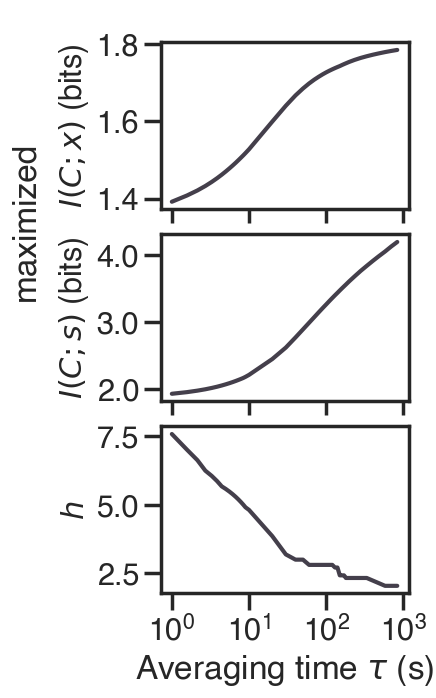

In [9]:
# FIGURE 2E: Maximized I(C;x), maximized I(C;s) and h at maximized $I(C;x) as a funciton of tau

# FIGURE SETTINGS 
sns.set_theme(context='poster', style='ticks', palette='deep', font='Helvetica', font_scale=1, color_codes=True, rc=None)
tau_lim = 1e3

### IMPORT DATA
datadir = "hillmode-koff_tau1-1000_h1-10_k3E-05-1E+00_kon1_koff1_n1_Sbins60_Cbins100_Ccov0.60"
loadpath = f"../Data/ModelData/{datadir}"

# Import parameters
with open(f"{loadpath}/parameters.json", "r") as file:
    parameters = json.load(file)
taus, hs, ks = parameters['taus'], parameters['hs'], parameters['ks']
tau_lim_idx = (np.abs(np.array(taus) - tau_lim)).argmin()
taus_plot = taus[:tau_lim_idx]

# Import the data
MI_all_df = pd.read_csv(f"{loadpath}/MIs_all.csv")
I_CX_test = np.reshape(MI_all_df['I_CX'],(len(hs), len(ks), len(taus)))[:,:,:tau_lim_idx]
I_CS_test = np.reshape(MI_all_df['I_CS'],(len(hs), len(ks), len(taus)))[:,:,:tau_lim_idx]


### CALCULATE the maximized MIs per tau 
best_ks = np.zeros(len(taus_plot))
best_hs = np.zeros(len(taus_plot))
best_I_CXs = np.zeros(len(taus_plot))
best_I_CSs = np.zeros(len(taus_plot))

for tau_idx in range(len(taus_plot)):
    # Take the h,k combination that gives the highest I(C;s)   
    h_idx, k_idx = np.unravel_index(np.argmax(I_CS_test[:, :, tau_idx]), I_CS_test[:, :, tau_idx].shape)    
    best_I_CSs[tau_idx] = I_CS_test[h_idx, k_idx, tau_idx]

    # Take the h,k combination that gives the highest I(C;x)   
    h_idx, k_idx = np.unravel_index(np.argmax(I_CX_test[:, :, tau_idx]), I_CX_test[:, :, tau_idx].shape)
    best_I_CXs[tau_idx] = I_CX_test[h_idx, k_idx, tau_idx]

    # Also store the values of h and k that give the highest I(C;x)
    best_ks[tau_idx] = ks[k_idx]
    best_hs[tau_idx] = hs[h_idx]
    
    
### PLOT     
# Plot max I(C;x), max I(C;s) and h at max I(C;x) over averaging time tau 
fig, axs = plt.subplots(3,1, figsize=(4.4,7.5), sharex=True)

# plot maximized I(C;x)
axs[0].plot(taus_plot, best_I_CXs, color='#443F4B', label=f'I(C;x)')
axs[0].set_ylabel(r'$I(C;x)$ (bits)', fontsize=22)
axs[0].set_yticks([1.4,1.6,1.8])
axs[0].tick_params(axis='x', which='major', bottom=True, top=False, length=10)
axs[0].set_title(' ')

# Plot maximized I(C;s)
axs[1].plot(taus_plot, best_I_CSs, color='#443F4B', label=f'I(C;s)')
axs[1].set_ylabel(r'$I(C;s)$ (bits)', fontsize=22)
axs[1].set_yticks([2.0, 3.0, 4.0])
axs[1].set_yticklabels(['2.0', '3.0', '4.0'])
axs[1].tick_params(axis='x', which='major', bottom=True, top=False, length=10)

# Plot h at maximized I(C;s)
axs[2].plot(taus_plot, best_hs, color='#443F4B', label=f'h')
axs[2].set_ylabel(r'$h$', fontsize=22)
axs[2].set_xlabel(r'Averaging time $\tau$ (s)')
axs[2].set_xscale('log')
axs[2].set_xticks([1e0, 1e1, 1e2, 1e3])

# Add 'maximized' title
BboxPosn = axs[0].get_position()
fig.text(BboxPosn.x0 - 0.15, BboxPosn.y0 - 0.08, r'maximized', fontsize=24, rotation=90)

# Final figure adjustments
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0.15) 

# Save figure
fig.savefig('../Figures/Figure2E.pdf', bbox_inches = 'tight', pad_inches=0.3)

### Figure 4B (and supplement Figure 8):
- Plots $I(C;x)$ in the $h$,$k$-plane and additionally plots the optimal $I(C;x)$ per $I(C;s)$ and per $h$. 
- Paper figure 4B uses data from: `hillmode-koff_tau10-600_h1-20_k3E-05-1E+00_kon1_koff1_n1_Sbins60_Cbins100_Ccov0.60` with `tau = 600` chosen.
- To plot the supplement Figure 8, change set `tau = 10` instead in the code below. 

/var/folders/rj/_5k7bwfs4f78f6vm4cy0cky9258p8x/T/ipykernel_8996/1952897589.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


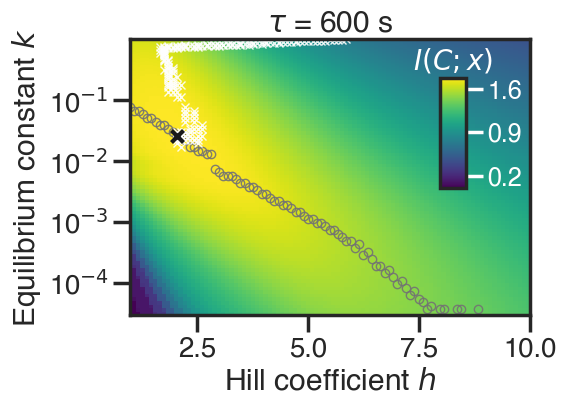

In [10]:
### FIGURE 4B: I(C;x) in the h,k-plane with optimal trajectories

### FIGURE SETTINGS
sns.set_theme(context='poster', style='ticks', palette='deep', font='Helvetica', font_scale=0.90, color_codes=True, rc=None)
tau = 600 # which tau to plot (alternatively can hardcode tau_idx)
plot_maximum = True # if True plot max MI as 'x' in h,k plane
remove_boundary = True # Whether or not to include optimal values that lie on the h,k boundary

### IMPORT DATA
datadir = "hillmode-koff_tau10-600_h1-20_k3E-05-1E+00_kon1_koff1_n1_Sbins60_Cbins100_Ccov0.60"
loadpath = f"../Data/ModelData/{datadir}"

# Import parameters
with open(f"{loadpath}/parameters.json", "r") as file:
    parameters = json.load(file)
taus, hs, ks = parameters['taus'], parameters['hs'], parameters['ks']
tau_idx = taus.index(tau)
hs_plot = np.array(hs)
ks_plot = np.array(ks)

# Import the data
MI_all_df = pd.read_csv(f"{loadpath}/MIs_all.csv")
I_CX_test = np.reshape(MI_all_df['I_CX'],(len(hs), len(ks), len(taus)))
I_CS_test = np.reshape(MI_all_df['I_CS'],(len(hs), len(ks), len(taus)))

MI_optimalh_df  = pd.read_csv(f"{loadpath}/MIs_optimal_h.csv")
optimalh_I_CXs  = np.reshape(MI_optimalh_df['optimalh_I_CX'], (len(hs), len(taus)))
optimalh_ks_ICX = np.reshape(MI_optimalh_df['optimalh_k_ICX'], (len(hs), len(taus)))

MI_optimal_df = pd.read_csv(f"{loadpath}/MIs_optimal.csv")
Nvals = MI_optimal_df[MI_optimal_df['tau'] == taus[0]].shape[0]
optimal_hs = np.reshape(MI_optimal_df['optimal_h'], (Nvals, len(taus)))
optimal_ks = np.reshape(MI_optimal_df['optimal_k'], (Nvals, len(taus)))
optimal_I_CXs = np.reshape(MI_optimal_df['optimal_I_CX'], (Nvals, len(taus)))

# Optional: set values that are near boundary to 0 since they might not be representative
if remove_boundary:
    # First remove boundary of optimal I(C;x) per I(C;s)
    if np.any(optimal_hs[:,tau_idx] <= hs[3]):
        optimal_hs[np.where(optimal_hs[:,tau_idx] <= hs[1])[0],tau_idx] = 0     
    if np.any(optimal_ks[:,tau_idx] >= ks[-3]):
        optimal_hs[:np.where(optimal_ks[:,tau_idx] >= ks[-1])[0][-1],tau_idx] = 0
    
    # Remove boundary of optimal I(C;x) per h 
    hs_plot[np.where(optimalh_ks_ICX[:,tau_idx] <= ks[0])[0]] = 0

### PLOT FIGURE
fig, ax = plt.subplots(1,1, figsize = (6,4.5))

# Plot I(C;x) heatmap
c1 = ax.pcolor(hs, np.log10(ks), I_CX_test[:, :, tau_idx].T, cmap='viridis')

# Set logarithmic ticks
ax.tick_params(axis='both', which='major')
ax.set_yticks([0,-1,-2,-3,-4])
ax.set_yticklabels(['10$^{0}$','10$^{-1}$', '10$^{-2}$', '10$^{-3}$', '10$^{-4}$'])

# Plot the optimal I(C;x) per h 
non_zero_hs_h = np.where(hs_plot != 0)[0]
ax.plot(hs_plot[non_zero_hs_h], np.log10(optimalh_ks_ICX[non_zero_hs_h,tau_idx]), 'o', fillstyle='none', markersize=6, color='#737373', alpha=0.9, label=f'tau={taus[tau_idx]}')

# Plot the optimal I(C;x) per I(C;s) 
non_zero_hs = np.where(optimal_hs[:, tau_idx] != 0)[0]
ax.plot(optimal_hs[non_zero_hs, tau_idx], np.log10(optimal_ks[non_zero_hs, tau_idx]), 'x', markersize=6, color='w', alpha=0.9, label=f'tau={taus[tau_idx]}')

# Plot the maximum of I(C;x) as an 'x'
if plot_maximum:
    max_IC_X_idx = np.where(I_CX_test[:,:, tau_idx] == I_CX_test[:,:, tau_idx].max())
    h_at_max, k_at_max = hs_plot[max_IC_X_idx[0]], ks_plot[max_IC_X_idx[1]]
    ax.scatter(h_at_max, np.log10(k_at_max), marker='x', color='k', s=75, linewidths=3, zorder=6)

# Colorbar for I(C;x) 
cax1 = inset_axes(ax, width="6.5%", height="40%", loc='lower right',
                bbox_to_anchor=(-0.16, 0.46, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
cbar1 = fig.colorbar(c1, cax=cax1)
cbar1.set_ticks(get_colorbar_ticks(I_CX_test[:, :, tau_idx]))
cbar1.ax.yaxis.set_tick_params(color='white', labelsize=18)
cbar1.ax.set_title(r'$I(C;x)$', color='white', fontsize=20)
plt.setp(plt.getp(cbar1.ax.axes, 'yticklabels'), color='white')

# Set figure labels and title
ax.set_ylabel(r'Equilibrium constant $k$')
ax.set_xlabel(r'Hill coefficient $h$')  
ax.set_title(r'$\tau$ = ' + f'{taus[tau_idx]} s')

# Final adjustments
ax.set_xlim([1,10])
plt.tight_layout()

# Save figure
plt.savefig('../Figures/Figure4B.png', dpi=300)


### Figure 4C + D
- 4C: Plots the information bottleneck, $I(C;x)$ vs $I(C;s)$, with binding devices.
- 4D: Plots the binding device curves from selected binding devices in 4C.  
- Paper figure uses data from: `hillmode-koff_tau10-600_h1-20_k3E-05-1E+00_kon1_koff1_n1_Sbins60_Cbins100_Ccov0.60`
- Plot in the same section as it relies on the chosen binding devices
- Note that the plotted binding site devices are hard coded for the most part and changing the data may therefore result in a bit of chaos or not work when the indices do not exist. 

/var/folders/rj/_5k7bwfs4f78f6vm4cy0cky9258p8x/T/ipykernel_8996/507459012.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


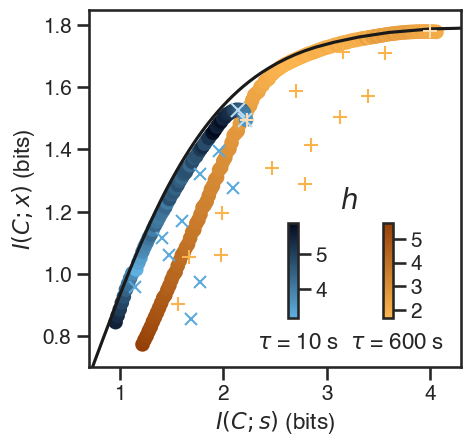

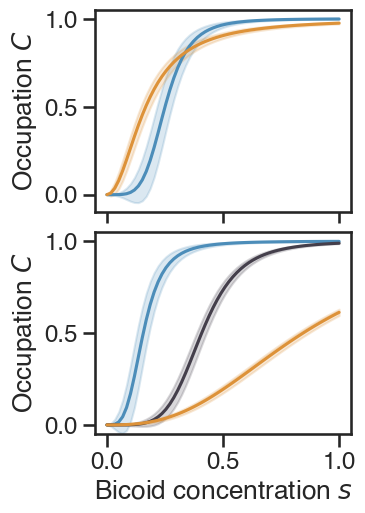

In [11]:
# FIGURE 4C + D: BINDING SITE DEVICES ON THE OPTIMAL PLANE

### FIGURE SETTINGS 
sns.set_theme(context='talk', style='ticks', palette='deep', font='Helvetica', font_scale=0.9, color_codes=True, rc=None)
remove_hk_boundary = True # Whether to remove the data that is very close to the h,k boundary 

### IMPORT DATA
datadir = "hillmode-koff_tau10-600_h1-20_k3E-05-1E+00_kon1_koff1_n1_Sbins60_Cbins100_Ccov0.60"
loadpath = f"../Data/ModelData/{datadir}"

# Import parameters
with open(f"{loadpath}/parameters.json", "r") as file:
    parameters = json.load(file)
taus, hs, ks = parameters['taus'], parameters['hs'], parameters['ks']
hillmode, koff, kon = parameters['hillmode'], parameters['koff'], parameters['kon']

# Import the data
MI_all_df = pd.read_csv(f"{loadpath}/MIs_all.csv")
I_CX_test = np.reshape(MI_all_df['I_CX'],(len(hs), len(ks), len(taus)))
I_CS_test = np.reshape(MI_all_df['I_CS'],(len(hs), len(ks), len(taus)))

MI_optimal_df = pd.read_csv(f"{loadpath}/MIs_optimal.csv")
Nvals = MI_optimal_df[MI_optimal_df['tau'] == taus[0]].shape[0]
optimal_hs = np.reshape(MI_optimal_df['optimal_h'], (Nvals, len(taus)))
optimal_ks = np.reshape(MI_optimal_df['optimal_k'], (Nvals, len(taus)))
optimal_I_CXs = np.reshape(MI_optimal_df['optimal_I_CX'], (Nvals, len(taus)))
I_CS_values = MI_optimal_df['I_CS_value'].unique()

# Import the information bottleneck 
I_CXs_IB = np.loadtxt(f"{loadpath}/I_CX_IB.csv")
I_CSs_IB = np.loadtxt(f"{loadpath}/I_CS_IB.csv")

### CALCULATE / SET BINDING SITE DEVICES TO PLOT 
# Find the h,k (idxs) for binding device at the maximum I(C;x) for low tau
max_idx0 = np.where(optimal_I_CXs[:,0] == optimal_I_CXs[:,0].max())[0][0]
best_h0, best_k0 = optimal_hs[max_idx0, 0], optimal_ks[max_idx0, 0]

# Find the h,k (idxs) for binding device at the maximum I(C;x) for high tau
max_idx1 = np.where(optimal_I_CXs[:,-1] == optimal_I_CXs[:,-1].max())[0][0]
best_h1, best_k1 = optimal_hs[max_idx1, -1], optimal_ks[max_idx1, -1]

# Set the h,k (idxs) for binding devices that overlap at same I(C;x), I(C;s) combination for all three taus
# These are hardcoded, but one could arguably automate this 
mixed_hidx0, mixed_kidx0 = 28, 26
mixed_hidx1, mixed_kidx1 = 42, 43 
mixed_hidx2, mixed_kidx2 = 18, 98 
mixed_h0, mixed_k0 = hs[mixed_hidx0], ks[mixed_kidx0]
mixed_h1, mixed_k1 = hs[mixed_hidx1], ks[mixed_kidx1]
mixed_h2, mixed_k2 = hs[mixed_hidx2], ks[mixed_kidx2]

# (Optional) Remove data that touches / is very close the h,k boundary
if remove_hk_boundary:
    for tau_idx in range(len(taus)):
        if np.any(optimal_hs[:,tau_idx] <= hs[3]):
            optimal_hs[np.where(optimal_hs[:,tau_idx] <= hs[3])[0],tau_idx] = 0     
        if np.any(optimal_ks[:,tau_idx] >= ks[-3]):
            optimal_hs[:np.where(optimal_ks[:,tau_idx] >= ks[-3])[0][-1],tau_idx] = 0

### PLOT FIGURE 4C
fig, ax = plt.subplots(figsize=(5, 4.75))
BboxPosn = ax.get_position()

# Plot the IB bound
ax.plot(I_CSs_IB,I_CXs_IB,'k')

# Plot the I(C;x) vs I(C;s) data for the high tau 
non_zero_hs_tau1 = np.where(optimal_hs[:, -1] != 0)[0] # Filter for the non zero values 
scatter2 = ax.scatter(I_CS_values[non_zero_hs_tau1], optimal_I_CXs[:, -1][non_zero_hs_tau1], c=optimal_hs[:, -1][non_zero_hs_tau1], cmap=new_oranges, label=f'T = {taus[1]}(s)')
cbar2 = fig.add_axes([BboxPosn.x0 + .67, BboxPosn.y0 + .19, 0.02, 0.2]) # Plot corresponding colorbar
color_bar2 = plt.colorbar(scatter2, cax=cbar2, orientation='vertical', ticks=[1,2,3,4,5,6])

# Plot the I(C;x) vs I(C;s) data for the low tau  
non_zero_hs_tau0 = np.where(optimal_hs[:, 0] != 0)[0]
scatter1 = ax.scatter(I_CS_values[non_zero_hs_tau0], optimal_I_CXs[:, 0][non_zero_hs_tau0], c=optimal_hs[:, 0][non_zero_hs_tau0], cmap=new_blues, label=f'T = {taus[0]}(s)')
cbar = fig.add_axes([BboxPosn.x0 + 0.48, BboxPosn.y0 + .19, 0.02, 0.2]) # Plot corresponding colorbar
color_bar1 = plt.colorbar(scatter1, cax=cbar, orientation='vertical', ticks=[1,2,3,4,5,6])

# Plot the markers for the binding devices corresponding to the maximum I(C;x) in both graphs
ax.plot(I_CS_values[max_idx0], optimal_I_CXs[max_idx0,0],'x',c='#BCDCF1',markersize=10, markeredgewidth=1.5)
ax.plot(I_CS_values[max_idx1], optimal_I_CXs[max_idx1,-1],'+',c='#FBDDB1',markersize=10, markeredgewidth=1.5)

# Plot the markers for random (but selected) binding devices for low tau
# # Note: these are hardcoded but one could also just make two random lists 
h_idxs = [64, 13, 116, 57, 27, 82, 102, 12, 16]
k_idxs = [51, 10, 18, 68, 8, 18, 17, 39, 0]
for i in range(len(h_idxs)):
    # print(h_idxs[i], k_idxs[i], f'{I_CS_test[h_idxs[i], k_idxs[i],0]:.2f}', f'{I_CX_test[h_idxs[i], k_idxs[i],0]:.2f}')
    ax.plot(I_CS_test[h_idxs[i], k_idxs[i],0], I_CX_test[h_idxs[i], k_idxs[i],0],'x',c='#5CAADB',markersize=8, markeredgewidth=1.5)

# Plot the markers for random (but selected) binding devices for high tau 
h_idxs = [64, 37, 57, 28, 1, 22, 25, 6, 34, 38, 49, 40]
k_idxs = [51, 93, 68, 18, 45, 53, 60, 26, 10, 69, 48,0]
for i in range(len(h_idxs)):
    # print(h_idxs[i], k_idxs[i], f'{I_CS_test[h_idxs[i], k_idxs[i],-1]:.2f}', f'{I_CX_test[h_idxs[i], k_idxs[i],-1]:.2f}')
    ax.plot(I_CS_test[h_idxs[i], k_idxs[i],-1], I_CX_test[h_idxs[i], k_idxs[i],-1],'+',c='#FBB44D',markersize=10, markeredgewidth=1.5)

# Plot the markers for the binding device where low and high tau overlap 
ax.plot(I_CS_test[mixed_hidx0, mixed_kidx0,0],I_CX_test[mixed_hidx0, mixed_kidx0,0],'x',c='#BCDCF1',markersize=10, markeredgewidth=1.5)
ax.plot(I_CS_test[mixed_hidx2, mixed_kidx2,-1],I_CX_test[mixed_hidx2, mixed_kidx2,-1],'+',c='#FBDDB1',markersize=10, markeredgewidth=1.5)

# Set the plot labels
ax.set_xlabel('$I(C;s)$ (bits)')
ax.set_ylabel('$I(C;x)$ (bits)')

# Set the plot limits
ax.set_xlim([0.7, 4.3])
ax.set_ylim([0.7, 1.85])

# Plot the text for the color bars 
ax.text(BboxPosn.x0 + 3.0, BboxPosn.y0 + 1.1, '$h$', fontsize=20)
ax.text(BboxPosn.x0 + 2.2, BboxPosn.y0 + 0.65, r'$\tau$'+f' = {taus[0]:.0f} s', fontsize=16)
ax.text(BboxPosn.x0 + 3.1, BboxPosn.y0 + 0.65, r'$\tau$'+f' = {taus[-1]:.0f} s', fontsize=16)

# Save figure
plt.tight_layout()
plt.savefig(f'../Figures/Figure4C.pdf')
plt.show()

###################################################
### PLOT FIGURE 4D
# Reset figure settings
sns.set_theme(context='talk', style='ticks', palette='deep', font='Helvetica', font_scale=1.05, color_codes=True, rc=None)
fig, ax= plt.subplots(2,1,figsize=(4,5.5),sharex='col')

# Set the concentrations to plot 
Ss_plot = np.linspace(0, 1, 60) 

# Plot the binding devices at the maximum I(C;x) for each tau in one panel
Cmeans, Cvars = calculate_mean_and_variance(best_h0, best_k0, Ss_plot, taus[0], mode=hillmode, koff=koff, kon=kon)
ax[0].plot(Ss_plot, Cmeans, color='#4C8DB9')
ax[0].fill_between(Ss_plot, Cmeans - np.sqrt(Cvars), Cmeans + np.sqrt(Cvars), color='#4C8DB9', alpha=0.2)

Cmeans, Cvars = calculate_mean_and_variance(best_h1, best_k1, Ss_plot, taus[1], mode=hillmode, koff=koff, kon=kon)
ax[0].plot(Ss_plot, Cmeans, color='#DD9239')
ax[0].fill_between(Ss_plot, Cmeans - np.sqrt(Cvars), Cmeans + np.sqrt(Cvars), color='#DD9239', alpha=0.2)

ax[0].tick_params(axis='x', which='major', bottom=True, top=False, length=8)

# Plot the binding devices overlapping at a similar I(C;x), I(C;s) combination for each tau in one panel
Cmeans, Cvars = calculate_mean_and_variance(mixed_h0, mixed_k0, Ss_plot, taus[0], mode=hillmode, koff=koff, kon=kon)
ax[1].plot(Ss_plot, Cmeans, color='#4C8DB9')
ax[1].fill_between(Ss_plot, Cmeans - np.sqrt(Cvars), Cmeans + np.sqrt(Cvars), color='#4C8DB9', alpha=0.2)

Cmeans, Cvars = calculate_mean_and_variance(mixed_h1, mixed_k1, Ss_plot, taus[1], mode=hillmode, koff=koff, kon=kon)
ax[1].plot(Ss_plot, Cmeans, color='#443F4B')
ax[1].fill_between(Ss_plot, Cmeans - np.sqrt(Cvars), Cmeans + np.sqrt(Cvars), color='#443F4B', alpha=0.2)

Cmeans, Cvars = calculate_mean_and_variance(mixed_h2, mixed_k2, Ss_plot, taus[-1], mode=hillmode, koff=koff, kon=kon)
ax[1].plot(Ss_plot, Cmeans, color='#DD9239')
ax[1].fill_between(Ss_plot, Cmeans - np.sqrt(Cvars), Cmeans + np.sqrt(Cvars), color='#DD9239', alpha=0.2)

# Set labels 
ax[1].set_xlabel(r'Bicoid concentration $s$')
ax[0].set_ylabel(r'Occupation $C$')
ax[1].set_ylabel(r'Occupation $C$')

# Set last figure specifications

plt.ylim([-0.05, 1.05])
plt.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0.1) 

# Save the figure
plt.savefig('../Figures/Figure4D.pdf', bbox_inches='tight', pad_inches=0.3)

### Figure 4E
- Plots the all the binding devices ($h,k$ combinations) for a range of $\tau$ values of (three) specific points along the information bottleneck line as plotted in Figure 4C. 
- Paper figure uses data from: `hillmode-koff_tau1-1000_h1-10_k3E-05-1E+00_kon1_koff1_n1_Sbins60_Cbins100_Ccov0.60`

Point 0: I_CX = 1.20, I_CS = 1.35
Point 1: I_CX = 1.60, I_CS = 2.20
Point 2: I_CX = 1.76, I_CS = 3.32


/var/folders/rj/_5k7bwfs4f78f6vm4cy0cky9258p8x/T/ipykernel_8996/1849861770.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


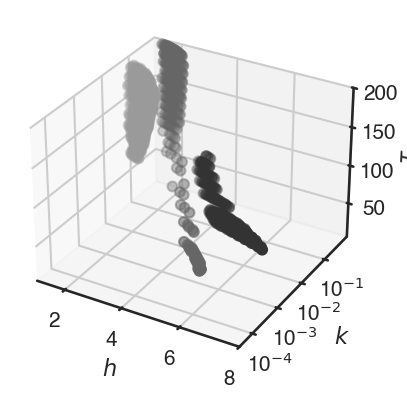

In [12]:
### FIGURE 4E: The binding devices ($h,k$ combinations) for a range of tau values of specific points along the information bottleneck line. 

### FIGURE SETTINGS
sns.set_theme(context='talk', style='ticks', palette='deep', font='Helvetica', font_scale=0.9)
set_tau_boundary = True # whether to set the boundary as indicated in the paper figure

IB_idxs = [15, 36, 47] # The points on IB line we want to plot;
# These preset ones correspond to the ones marked in Figure 4C in the paper figure

### IMPORT DATA
datadir = "hillmode-koff_tau1-1000_h1-10_k3E-05-1E+00_kon1_koff1_n1_Sbins60_Cbins100_Ccov0.60"
loadpath = f"../Data/ModelData/{datadir}"

# Import parameters
with open(f"{loadpath}/parameters.json", "r") as file:
    parameters = json.load(file)
taus, hs, ks = np.array(parameters['taus']), np.array(parameters['hs']), np.array(parameters['ks'])

# Import the data
MI_all_df = pd.read_csv(f"{loadpath}/MIs_all.csv")
I_CX_test = np.reshape(MI_all_df['I_CX'],(len(hs), len(ks), len(taus)))
I_CS_test = np.reshape(MI_all_df['I_CS'],(len(hs), len(ks), len(taus)))

# Import the information bottleneck 
I_CXs_IB = np.loadtxt(f"{loadpath}/I_CX_IB.csv")
I_CSs_IB = np.loadtxt(f"{loadpath}/I_CS_IB.csv")

### OPTIONAL
# Reset tau boundaries from imported data to only include taus 5 to 200 (can be made more variable..)
if set_tau_boundary:
    tau_idx_5 = np.where(taus==5)[0][0]
    tau_idx_200 = np.where(taus==200)[0][0]
    taus = taus[tau_idx_5:tau_idx_200+1]
    I_CX_test = I_CX_test[:,:,tau_idx_5:tau_idx_200+1]
    I_CS_test = I_CS_test[:,:,tau_idx_5:tau_idx_200+1]

### PLOT FIGURE
# Plot the 3D figure
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.65, 0.12, 0.45, 0.79],projection="3d")
for i in range(len(IB_idxs)):
    ref_I_CS = I_CSs_IB[IB_idxs[i]]
    ref_I_CX = I_CXs_IB[IB_idxs[i]]
    print(f'Point {i}: I_CX = {ref_I_CX:.2f}, I_CS = {ref_I_CS:.2f}')
    h_idxs, k_idxs, tau_idxs = np.where((np.abs(I_CS_test-ref_I_CS)<4e-2) & (np.abs(I_CX_test-ref_I_CX)<4e-2))
    ax.scatter(hs[h_idxs], np.log10(ks[k_idxs]), taus[tau_idxs], color=new_blacks((i+1)/(len(IB_idxs)+1)), s=50)

# Set limits and labels
ax.set_xlim([1,8])
ax.set_ylim([-4.5,0])
ax.set_zlim([5,200])
ax.set_yticks([-4,-3,-2,-1])
ax.set_yticklabels(['10$^{-4}$','10$^{-3}$','10$^{-2}$','10$^{-1}$'])
ax.set_xlabel(r'$h$',labelpad=8)
ax.set_ylabel(r'$k$',labelpad=10)
ax.set_zlabel(r'$\tau$',labelpad=5)
plt.tight_layout()

# Save figure
plt.savefig(f'../Figures/Figure2E.pdf', bbox_inches='tight', pad_inches=0.3)

### Supplement Figure 5A
- Same as Figure 2C but with $k_{on}$ set as constant at value $k_{on} = 10$ and both $\tau$'s plotted at once
- Paper figure uses data from: `hillmode-kon_tau10-600_h1-20_k3E-05-1E+00_kon10_koff1_n1_Sbins60_Cbins100_Ccov0.60`

I(C;x) max = 1.33 bits at h = 1.67 and k = 9.90E-01
I(C;s) max = 1.71 bits at h = 1.48 and k = 9.90E-01
I(C;x) max = 1.78 bits at h = 1.19 and k = 5.36E-01
I(C;s) max = 4.04 bits at h = 1.19 and k = 5.50E-01


/var/folders/rj/_5k7bwfs4f78f6vm4cy0cky9258p8x/T/ipykernel_8996/1276061043.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


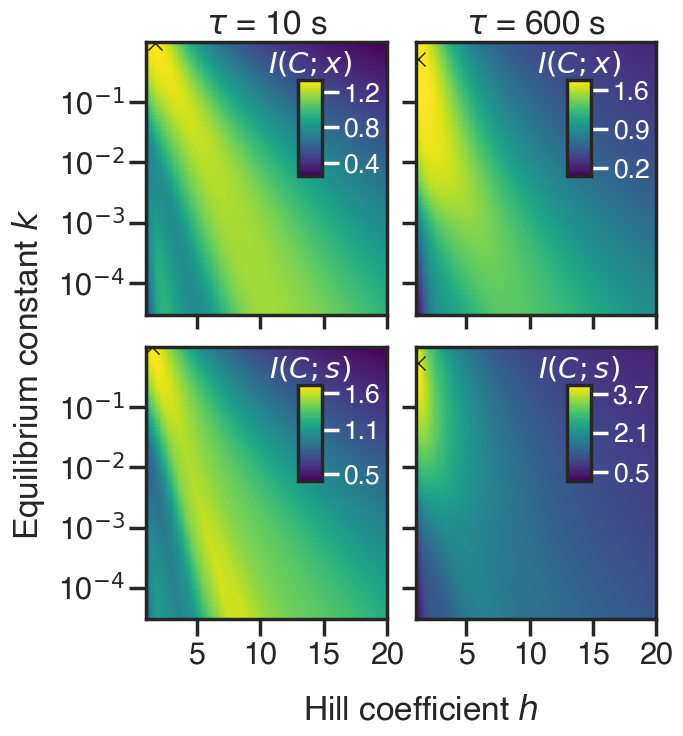

In [13]:
# SUPPLEMENT FIGURE 5A: Mutual information in the h,k-plane with kon constant

### FIGURE SETTINGS
sns.set_theme(context='poster', style='ticks', palette='deep', font='Helvetica', font_scale=1.0)
taus_to_plot = [10, 600] 
plot_maximum = True # if True plot max MI as 'x' in h,k plane

### IMPORT DATA
datadir = "hillmode-kon_tau10-600_h1-20_k3E-05-1E+00_kon10_koff1_n1_Sbins60_Cbins100_Ccov0.60"
loadpath = f"../Data/ModelData/{datadir}"

# Import parameters
with open(f"{loadpath}/parameters.json", "r") as file:
    parameters = json.load(file)
taus, hs, ks = parameters['taus'], parameters['hs'], parameters['ks']
tau_idx = taus.index(tau)

# Import the data
MI_all_df = pd.read_csv(f"{loadpath}/MIs_all.csv")
I_CX_test = np.reshape(MI_all_df['I_CX'],(len(hs), len(ks), len(taus)))
I_CS_test = np.reshape(MI_all_df['I_CS'],(len(hs), len(ks), len(taus)))

# Find indices for the taus to plot
tau_indices = [taus.index(t) for t in taus_to_plot]

### PLOT FIGURE
fig, axs = plt.subplots(2, 2, figsize=(7.6, 8), sharex=True, sharey=True)

for i, tau_idx in enumerate(tau_indices):
    # Plot I(C;x)
    c1 = axs[0, i].pcolor(hs, np.log10(ks), I_CX_test[:, :, tau_idx].T, cmap='viridis')
    axs[0, i].set_title(r'$\tau$' + f' = {taus[tau_idx]} s')
    axs[0, i].tick_params(axis='both', which='major')
    axs[0, i].set_yticks([-1, -2, -3, -4])
    axs[0, i].set_yticklabels(['10$^{-1}$', '10$^{-2}$', '10$^{-3}$', '10$^{-4}$'])
    axs[0, i].tick_params(axis='x', which='major', bottom=True, top=False, length=10)

    # Plot I(C;s)
    c2 = axs[1, i].pcolor(hs, np.log10(ks), I_CS_test[:, :, tau_idx].T, cmap='viridis')
    axs[1, i].tick_params(axis='both', which='major')
    axs[1, i].set_xlim([1, 10])
    axs[1, i].set_xticks([5, 10, 15, 20])

    # Shorten axes ticks
    axs[0, i].tick_params(axis='x', which='major', bottom=True, top=False, length=10)
    if i == 1:
        axs[0, i].tick_params(axis='y', which='major', bottom=True, top=False, length=10)
        axs[1, i].tick_params(axis='y', which='major', bottom=True, top=False, length=10)

    # Plot the h,k of maximum MI as 'x'
    if plot_maximum:
        max_IC_X_idx = np.where(I_CX_test[:, :, tau_idx] == I_CX_test[:, :, tau_idx].max())
        h_at_max, k_at_max = hs[max_IC_X_idx[0][0]], ks[max_IC_X_idx[1][0]]
        axs[0, i].plot(h_at_max, np.log10(k_at_max),'x', color='k', markersize=10)
        print( f'I(C;x) max = {I_CX_test[:, :, tau_idx].max():.2f} bits at h = {h_at_max:.2f} and k = {k_at_max:.2E}')

        max_IC_S_idx = np.where(I_CS_test[:, :, tau_idx] == I_CS_test[:, :, tau_idx].max())
        h_at_max, k_at_max = hs[max_IC_S_idx[0][0]], ks[max_IC_S_idx[1][0]]
        axs[1, i].plot(h_at_max, np.log10(k_at_max),'x', color='k', markersize=10)
        print(f'I(C;s) max = {I_CS_test[:, :, tau_idx].max():.2f} bits at h = {h_at_max:.2f} and k = {k_at_max:.2E}')

    # Colorbar for I(C;x) row
    cax1 = inset_axes(axs[0, i], width="10%", height="35%", loc='lower right',
                      bbox_to_anchor=(-0.27, 0.51, 1, 1), bbox_transform=axs[0, i].transAxes, borderpad=0)
    cbar1 = fig.colorbar(c1, cax=cax1)
    cbar1.set_ticks(get_colorbar_ticks(I_CX_test[:, :, tau_idx]))
    cbar1.ax.yaxis.set_tick_params(color='white', labelsize=19)
    cbar1.ax.set_title(r'$I(C;x)$', color='white', fontsize=21)
    plt.setp(plt.getp(cbar1.ax.axes, 'yticklabels'), color='white')

    # Colorbar for I(C;s) row
    cax2 = inset_axes(axs[1, i], width="10%", height="35%", loc='lower right',
                      bbox_to_anchor=(-0.27, 0.51, 1, 1), bbox_transform=axs[1, i].transAxes, borderpad=0)
    cbar2 = fig.colorbar(c2, cax=cax2)
    cbar2.set_ticks(get_colorbar_ticks(I_CS_test[:, :, tau_idx]))
    cbar2.ax.yaxis.set_tick_params(color='white', labelsize=19)
    cbar2.ax.set_title(r'$I(C;s)$', color='white', fontsize=21)
    plt.setp(plt.getp(cbar2.ax.axes, 'yticklabels'), color='white')

# Set shared axis labels
fig.supylabel(r'Equilibrium constant $k$', x=0.08, fontsize=24)
fig.supxlabel(r'Hill coefficient $h$', x=0.62, y=0.06, fontsize=24)

# Final adjustments
fig.tight_layout()
fig.subplots_adjust(wspace=0.12, hspace=0.12)

# Save figure
plt.savefig(f'../Figures/SupFigure5A.png', dpi=300)


### Supplement Figure 5B
- Same as Figure 2C but with extended $k$-range and both $\tau$'s plotted at once
- Paper figure uses data from: `hillmode-koff_tau10-600_h1-20_k1E-10-5E+00_kon1_koff1_n1_Sbins60_Cbins100_Ccov0.60`

I(C;x) max = 1.53 bits at h = 4.63 and k = 1.48E-03
I(C;s) max = 2.21 bits at h = 3.67 and k = 7.32E-04
I(C;x) max = 1.78 bits at h = 2.15 and k = 2.45E-02
I(C;s) max = 4.07 bits at h = 2.05 and k = 1.73E-02


/var/folders/rj/_5k7bwfs4f78f6vm4cy0cky9258p8x/T/ipykernel_8996/1856049002.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


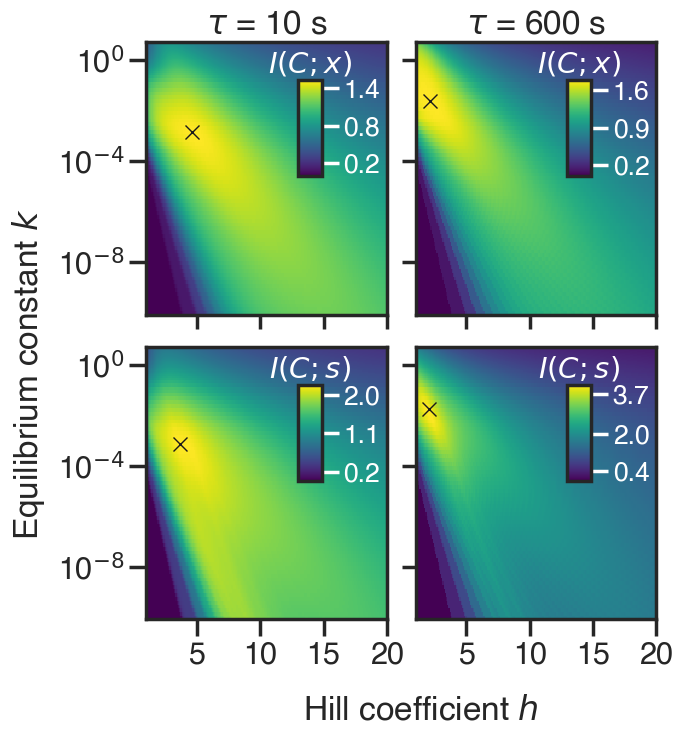

In [14]:
# SUPPLEMENT FIGURE 5B: Mutual information in the h,k-plane with extended k-range

### FIGURE SETTINGS
sns.set_theme(context='poster', style='ticks', palette='deep', font='Helvetica', font_scale=1.0)
taus_to_plot = [10, 600] 
plot_maximum = True # if True plot max MI as 'x' in h,k plane

### IMPORT DATA
datadir = "hillmode-koff_tau10-600_h1-20_k1E-10-5E+00_kon1_koff1_n1_Sbins60_Cbins100_Ccov0.60"
loadpath = f"../Data/ModelData/{datadir}"

# Import parameters
with open(f"{loadpath}/parameters.json", "r") as file:
    parameters = json.load(file)
taus, hs, ks = parameters['taus'], parameters['hs'], parameters['ks']

# Import the data
MI_all_df = pd.read_csv(f"{loadpath}/MIs_all.csv")
I_CX_test = np.reshape(MI_all_df['I_CX'],(len(hs), len(ks), len(taus)))
I_CS_test = np.reshape(MI_all_df['I_CS'],(len(hs), len(ks), len(taus)))

# Find indices for the taus to plot
tau_indices = [taus.index(t) for t in taus_to_plot]

### PLOT FIGURE
fig, axs = plt.subplots(2, 2, figsize=(7.6, 8), sharex=True, sharey=True)

for i, tau_idx in enumerate(tau_indices):
    # Plot I(C;x)
    c1 = axs[0, i].pcolor(hs, np.log10(ks), I_CX_test[:, :, tau_idx].T, cmap='viridis')
    axs[0, i].set_title(r'$\tau$' + f' = {taus[tau_idx]} s')
    axs[0, i].tick_params(axis='both', which='major')
    axs[0, i].set_yticks([0, -4, -8])
    axs[0, i].set_yticklabels(['10$^{0}$','10$^{-4}$', '10$^{-8}$'])
    

    # Plot I(C;s)
    c2 = axs[1, i].pcolor(hs, np.log10(ks), I_CS_test[:, :, tau_idx].T, cmap='viridis')
    axs[1, i].tick_params(axis='both', which='major')
    axs[1, i].set_xlim([1, 10])
    axs[1, i].set_xticks([5, 10, 15, 20])

    # Shorten axes ticks
    axs[0, i].tick_params(axis='x', which='major', bottom=True, top=False, length=10)
    if i == 1:
        axs[0, i].tick_params(axis='y', which='major', bottom=True, top=False, length=10)
        axs[1, i].tick_params(axis='y', which='major', bottom=True, top=False, length=10)
    
    # Plot the h,k of maximum MI as 'x'
    if plot_maximum:
        max_IC_X_idx = np.where(I_CX_test[:, :, tau_idx] == I_CX_test[:, :, tau_idx].max())
        h_at_max, k_at_max = hs[max_IC_X_idx[0][0]], ks[max_IC_X_idx[1][0]]
        axs[0, i].plot(h_at_max, np.log10(k_at_max),'x', color='k', markersize=10)
        print( f'I(C;x) max = {I_CX_test[:, :, tau_idx].max():.2f} bits at h = {h_at_max:.2f} and k = {k_at_max:.2E}')

        max_IC_S_idx = np.where(I_CS_test[:, :, tau_idx] == I_CS_test[:, :, tau_idx].max())
        h_at_max, k_at_max = hs[max_IC_S_idx[0][0]], ks[max_IC_S_idx[1][0]]
        axs[1, i].plot(h_at_max, np.log10(k_at_max),'x', color='k', markersize=10)
        print(f'I(C;s) max = {I_CS_test[:, :, tau_idx].max():.2f} bits at h = {h_at_max:.2f} and k = {k_at_max:.2E}')

    # Colorbar for I(C;x) row
    cax1 = inset_axes(axs[0, i], width="10%", height="35%", loc='lower right',
                      bbox_to_anchor=(-0.27, 0.51, 1, 1), bbox_transform=axs[0, i].transAxes, borderpad=0)
    cbar1 = fig.colorbar(c1, cax=cax1)
    cbar1.set_ticks(get_colorbar_ticks(I_CX_test[:, :, tau_idx]))
    cbar1.ax.yaxis.set_tick_params(color='white', labelsize=19)
    cbar1.ax.set_title(r'$I(C;x)$', color='white', fontsize=21)
    plt.setp(plt.getp(cbar1.ax.axes, 'yticklabels'), color='white')

    # Colorbar for I(C;s) row
    cax2 = inset_axes(axs[1, i], width="10%", height="35%", loc='lower right',
                      bbox_to_anchor=(-0.27, 0.51, 1, 1), bbox_transform=axs[1, i].transAxes, borderpad=0)
    cbar2 = fig.colorbar(c2, cax=cax2)
    cbar2.set_ticks(get_colorbar_ticks(I_CS_test[:, :, tau_idx]))
    cbar2.ax.yaxis.set_tick_params(color='white', labelsize=19)
    cbar2.ax.set_title(r'$I(C;s)$', color='white', fontsize=21)
    plt.setp(plt.getp(cbar2.ax.axes, 'yticklabels'), color='white')

# Set shared axis labels
fig.supylabel(r'Equilibrium constant $k$', x=0.08, fontsize=24)
fig.supxlabel(r'Hill coefficient $h$', x=0.62, y=0.06, fontsize=24)

# Final adjustments
fig.tight_layout()
fig.subplots_adjust(wspace=0.12, hspace=0.12)

# Save figure
plt.savefig(f'../Figures/SupFigure5B.png', dpi=300)


### Supplement Figure 6A
- Same as Figure 2C (where C_bins = 100) and additionally with C_bins = 1000 for tau = 10
- Paper figure uses data from: `hillmode-koff_tau10-600_h1-20_k3E-05-1E+00_kon1_koff1_n1_Sbins60_Cbins100_Ccov0.60` and from `hillmode-koff_tau10-600_h1-20_k3E-05-1E+00_kon1_koff1_n1_Sbins60_Cbins1000_Ccov0.60`. 

I(C;x) max = 1.78 bits at h = 2.05 and k = 2.55E-02
I(C;s) max = 4.07 bits at h = 2.05 and k = 1.48E-02
I(C;x) max = 1.79 bits at h = 2.81 and k = 2.87E-03
I(C;s) max = 4.44 bits at h = 2.81 and k = 1.90E-03


/var/folders/rj/_5k7bwfs4f78f6vm4cy0cky9258p8x/T/ipykernel_8996/232842020.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


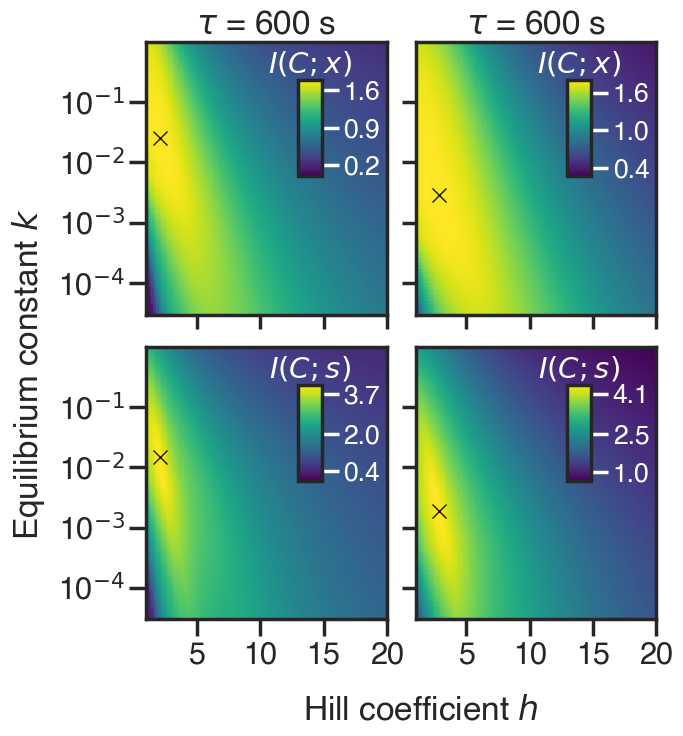

In [15]:
# SUPPLEMENT FIGURE 6A: Mutual information in the h,k-plane with increased Cbins

### FIGURE SETTINGS
sns.set_theme(context='poster', style='ticks', palette='deep', font='Helvetica', font_scale=1.0)
tau_to_plot = 10
plot_maximum = True # if True plot max MI as 'x' in h,k plane

### NOTE: This figure uses two parts, one with the original data where Cbins = 100 and one with Cbins=1000 


### PLOT FIGURE
fig, axs = plt.subplots(2, 2, figsize=(7.6, 8), sharex=True, sharey=True)

############ PART 1: Original data with Cbins=100
### IMPORT DATA
datadir = "hillmode-koff_tau10-600_h1-20_k3E-05-1E+00_kon1_koff1_n1_Sbins60_Cbins100_Ccov0.60"
loadpath = f"../Data/ModelData/{datadir}"

# Import parameters
with open(f"{loadpath}/parameters.json", "r") as file:
    parameters = json.load(file)
taus, hs, ks = parameters['taus'], parameters['hs'], parameters['ks']
tau_idx = taus.index(tau)

# Import the data
MI_all_df = pd.read_csv(f"{loadpath}/MIs_all.csv")
I_CX_test = np.reshape(MI_all_df['I_CX'],(len(hs), len(ks), len(taus)))
I_CS_test = np.reshape(MI_all_df['I_CS'],(len(hs), len(ks), len(taus)))


# Plot I(C;x)
c1 = axs[0, 0].pcolor(hs, np.log10(ks), I_CX_test[:, :, tau_idx].T, cmap='viridis')
axs[0, 0].set_title(r'$\tau$' + f' = {taus[tau_idx]} s')
axs[0, 0].tick_params(axis='both', which='major')
axs[0, 0].set_yticks([-1, -2, -3, -4])
axs[0, 0].set_yticklabels(['10$^{-1}$', '10$^{-2}$', '10$^{-3}$', '10$^{-4}$'])
axs[0, 0].tick_params(axis='x', which='major', bottom=True, top=False, length=10)

# Plot I(C;s)
c2 = axs[1, 0].pcolor(hs, np.log10(ks), I_CS_test[:, :, tau_idx].T, cmap='viridis')
axs[1, 0].tick_params(axis='both', which='major')
axs[1, 0].set_xlim([1, 10])
axs[1, 0].set_xticks([5, 10, 15, 20])

# Shorten axes ticks
axs[0, 0].tick_params(axis='x', which='major', bottom=True, top=False, length=10)

# Plot the h,k of maximum MI as 'x'
if plot_maximum:
    max_IC_X_idx = np.where(I_CX_test[:, :, tau_idx] == I_CX_test[:, :, tau_idx].max())
    h_at_max, k_at_max = hs[max_IC_X_idx[0][0]], ks[max_IC_X_idx[1][0]]
    axs[0, 0].plot(h_at_max, np.log10(k_at_max),'x', color='k', markersize=10)
    print( f'I(C;x) max = {I_CX_test[:, :, tau_idx].max():.2f} bits at h = {h_at_max:.2f} and k = {k_at_max:.2E}')

    max_IC_S_idx = np.where(I_CS_test[:, :, tau_idx] == I_CS_test[:, :, tau_idx].max())
    h_at_max, k_at_max = hs[max_IC_S_idx[0][0]], ks[max_IC_S_idx[1][0]]
    axs[1, 0].plot(h_at_max, np.log10(k_at_max),'x', color='k', markersize=10)
    print(f'I(C;s) max = {I_CS_test[:, :, tau_idx].max():.2f} bits at h = {h_at_max:.2f} and k = {k_at_max:.2E}')

# Colorbar for I(C;x) row
cax1 = inset_axes(axs[0, 0], width="10%", height="35%", loc='lower right',
                    bbox_to_anchor=(-0.27, 0.51, 1, 1), bbox_transform=axs[0, 0].transAxes, borderpad=0)
cbar1 = fig.colorbar(c1, cax=cax1)
cbar1.set_ticks(get_colorbar_ticks(I_CX_test[:, :, tau_idx]))
cbar1.ax.yaxis.set_tick_params(color='white', labelsize=19)
cbar1.ax.set_title(r'$I(C;x)$', color='white', fontsize=21)
plt.setp(plt.getp(cbar1.ax.axes, 'yticklabels'), color='white')

# Colorbar for I(C;s) row
cax2 = inset_axes(axs[1, 0], width="10%", height="35%", loc='lower right',
                    bbox_to_anchor=(-0.27, 0.51, 1, 1), bbox_transform=axs[1, 0].transAxes, borderpad=0)
cbar2 = fig.colorbar(c2, cax=cax2)
cbar2.set_ticks(get_colorbar_ticks(I_CS_test[:, :, tau_idx]))
cbar2.ax.yaxis.set_tick_params(color='white', labelsize=19)
cbar2.ax.set_title(r'$I(C;s)$', color='white', fontsize=21)
plt.setp(plt.getp(cbar2.ax.axes, 'yticklabels'), color='white')

############ PART 1: Original data with Cbins=100
### IMPORT DATA
datadir = "hillmode-koff_tau10-600_h1-20_k3E-05-1E+00_kon1_koff1_n1_Sbins60_Cbins1000_Ccov0.60"
loadpath = f"../Data/ModelData/{datadir}"

# Import parameters
with open(f"{loadpath}/parameters.json", "r") as file:
    parameters = json.load(file)
taus, hs, ks = parameters['taus'], parameters['hs'], parameters['ks']
tau_idx = taus.index(tau)

# Import the data
MI_all_df = pd.read_csv(f"{loadpath}/MIs_all.csv")
I_CX_test = np.reshape(MI_all_df['I_CX'],(len(hs), len(ks), len(taus)))
I_CS_test = np.reshape(MI_all_df['I_CS'],(len(hs), len(ks), len(taus)))

# Plot I(C;x)
c1 = axs[0, 1].pcolor(hs, np.log10(ks), I_CX_test[:, :, tau_idx].T, cmap='viridis')
axs[0, 1].set_title(r'$\tau$' + f' = {taus[tau_idx]} s')
axs[0, 1].tick_params(axis='both', which='major')
axs[0, 1].set_yticks([-1, -2, -3, -4])
axs[0, 1].set_yticklabels(['10$^{-1}$', '10$^{-2}$', '10$^{-3}$', '10$^{-4}$'])

# Plot I(C;s)
c2 = axs[1, 1].pcolor(hs, np.log10(ks), I_CS_test[:, :, tau_idx].T, cmap='viridis')
axs[1, 1].tick_params(axis='both', which='major')
axs[1, 1].set_xlim([1, 10])
axs[1, 1].set_xticks([5, 10, 15, 20])

# Shorten axes ticks
axs[0, 1].tick_params(axis='x', which='major', bottom=True, top=False, length=10)
if i == 1:
    axs[0, 1].tick_params(axis='y', which='major', bottom=True, top=False, length=10)
    axs[1, 1].tick_params(axis='y', which='major', bottom=True, top=False, length=10)

# Plot the h,k of maximum MI as 'x'
if plot_maximum:
    max_IC_X_idx = np.where(I_CX_test[:, :, tau_idx] == I_CX_test[:, :, tau_idx].max())
    h_at_max, k_at_max = hs[max_IC_X_idx[0][0]], ks[max_IC_X_idx[1][0]]
    axs[0, 1].plot(h_at_max, np.log10(k_at_max),'x', color='k', markersize=10)
    print( f'I(C;x) max = {I_CX_test[:, :, tau_idx].max():.2f} bits at h = {h_at_max:.2f} and k = {k_at_max:.2E}')

    max_IC_S_idx = np.where(I_CS_test[:, :, tau_idx] == I_CS_test[:, :, tau_idx].max())
    h_at_max, k_at_max = hs[max_IC_S_idx[0][0]], ks[max_IC_S_idx[1][0]]
    axs[1, 1].plot(h_at_max, np.log10(k_at_max),'x', color='k', markersize=10)
    print(f'I(C;s) max = {I_CS_test[:, :, tau_idx].max():.2f} bits at h = {h_at_max:.2f} and k = {k_at_max:.2E}')

# Colorbar for I(C;x) row
cax1 = inset_axes(axs[0, 1], width="10%", height="35%", loc='lower right',
                    bbox_to_anchor=(-0.27, 0.51, 1, 1), bbox_transform=axs[0, 1].transAxes, borderpad=0)
cbar1 = fig.colorbar(c1, cax=cax1)
cbar1.set_ticks(get_colorbar_ticks(I_CX_test[:, :, tau_idx]))
cbar1.ax.yaxis.set_tick_params(color='white', labelsize=19)
cbar1.ax.set_title(r'$I(C;x)$', color='white', fontsize=21)
plt.setp(plt.getp(cbar1.ax.axes, 'yticklabels'), color='white')

# Colorbar for I(C;s) row
cax2 = inset_axes(axs[1, 1], width="10%", height="35%", loc='lower right',
                    bbox_to_anchor=(-0.27, 0.51, 1, 1), bbox_transform=axs[1, 1].transAxes, borderpad=0)
cbar2 = fig.colorbar(c2, cax=cax2)
cbar2.set_ticks(get_colorbar_ticks(I_CS_test[:, :, tau_idx]))
cbar2.ax.yaxis.set_tick_params(color='white', labelsize=19)
cbar2.ax.set_title(r'$I(C;s)$', color='white', fontsize=21)
plt.setp(plt.getp(cbar2.ax.axes, 'yticklabels'), color='white')

### PART 3: Finalize the figure

# Set shared axis labels
fig.supylabel(r'Equilibrium constant $k$', x=0.08, fontsize=24)
fig.supxlabel(r'Hill coefficient $h$', x=0.62, y=0.06, fontsize=24)

# Final adjustments
fig.tight_layout()
fig.subplots_adjust(wspace=0.12, hspace=0.12)

# Save figure
plt.savefig(f'../Figures/SupFigure6A.png', dpi=300)


### Supplement Figure 6B
- Same as Figure 2D but with C_bins = 1000 for tau = 10
- Paper figure uses data from: `hillmode-koff_tau10-600_h1-20_k1E-10-5E+00_kon1_koff1_n1_Sbins60_Cbins1000_Ccov0.60`. 

For t = 10 s: I(C;x) maximum = 1.62 bits at h = 6.92, I(C;s) maximum = 2.61 bits at h = 5.20
For t = 600 s: I(C;x) maximum = 1.79 bits at h = 2.72, I(C;s) maximum = 4.43 bits at h = 2.81


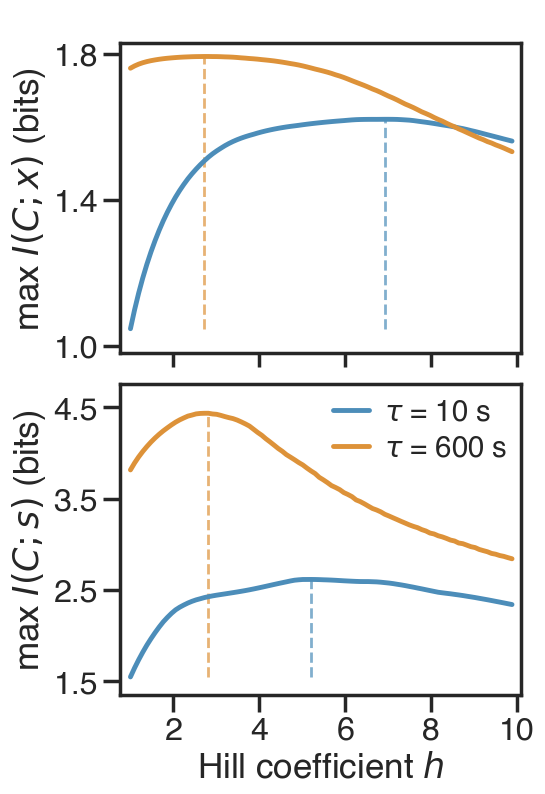

In [16]:
### FIGURE 2D: Maximum I(C;x) vs h and maximum I(C;s) vs h 

### FIGURE SETTINGS 
sns.set_theme(context='poster', style='ticks', palette='deep', font='Helvetica', 
              font_scale=1.05, color_codes=True, rc=None)
h_lim = 10 # Cut-off the data at this h value for 
remove_k_boundary = True # Whether or not to include MI values that lie on the k boundary

### IMPORT DATA
datadir = "hillmode-koff_tau10-600_h1-20_k1E-10-5E+00_kon1_koff1_n1_Sbins60_Cbins1000_Ccov0.60"
loadpath = f"../Data/ModelData/{datadir}"

# Import parameters
with open(f"{loadpath}/parameters.json", "r") as file:
    parameters = json.load(file)
taus, hs, ks = parameters['taus'], parameters['hs'], parameters['ks']
h_lim_idx = (np.abs(np.array(hs) - h_lim)).argmin()

# Import the relevant data
MI_optimalh_df  = pd.read_csv(f"{loadpath}/MIs_optimal_h.csv")
optimalh_I_CXs  = np.reshape(MI_optimalh_df['optimalh_I_CX'], (len(hs), len(taus)))[:h_lim_idx, :]
optimalh_I_CSs  = np.reshape(MI_optimalh_df['optimalh_I_CS'], (len(hs), len(taus)))[:h_lim_idx, :]
optimalh_ks_ICX = np.reshape(MI_optimalh_df['optimalh_k_ICX'], (len(hs), len(taus)))[:h_lim_idx, :]
optimalh_ks_ICS = np.reshape(MI_optimalh_df['optimalh_k_ICS'], (len(hs), len(taus)))[:h_lim_idx, :]
hs_plot = hs[:h_lim_idx]

# Optional: set values that hit k-boundary to 0 since they might not be representative
if remove_k_boundary:
    for tau_idx in range(len(taus)):
        optimalh_I_CXs[optimalh_ks_ICX[:, tau_idx] <= ks[1]] = 0 
        optimalh_I_CSs[optimalh_ks_ICS[:, tau_idx] <= ks[1]] = 0

### PLOT FIGURE
fig, axs = plt.subplots(2,1,figsize=(6,8.5), sharex=True)

# Plot maximum I(C;x) vs h 
ymin = 0.98
ymax = 1.83 
axs[0].axvline(hs_plot[np.argmax(optimalh_I_CXs[:,-1])], (np.min(optimalh_I_CXs[:,0]) - ymin) / (ymax - ymin), (np.max(optimalh_I_CXs[:,-1]) - ymin) / (ymax - ymin), linestyle='--', c='#DD9239', linewidth=2, alpha=0.7)
axs[0].axvline(hs_plot[np.argmax(optimalh_I_CXs[:,0])], (np.min(optimalh_I_CXs[:,0]) - ymin) / (ymax - ymin), (np.max(optimalh_I_CXs[:,0]) - ymin) / (ymax - ymin), linestyle='--', c='#4C8DB9', linewidth=2,alpha=0.7)
axs[0].plot(hs_plot, optimalh_I_CXs[:, 0], '-', color='#4C8DB9', markersize=5, label=r'$\tau$'+f' = {taus[0]} s', linewidth=3.5)
axs[0].plot(hs_plot, optimalh_I_CXs[:, -1], '-', color='#DD9239', markersize=5, label=r'$\tau$'+f' = {taus[-1]} s', linewidth=3.5)
axs[0].set_ylabel(r'max $I(C;x)$ (bits)')
axs[0].tick_params(axis='x', which='major', bottom=True, top=False, length=10)
axs[0].set_title(' ')
axs[0].set_ylim([ymin, ymax])
axs[0].set_yticks([1., 1.4, 1.8])
axs[0].set_xticks([2, 4, 6, 8, 10])
axs[0].set_xlim([0.75, h_lim+0.1])

# Plot maximum I(C;s) vs h 
ymin = 1.35 
ymax = 4.75
axs[1].axvline(hs_plot[np.argmax(optimalh_I_CSs[:,-1])], (np.min(optimalh_I_CSs[:,0]) - ymin) / (ymax - ymin), (np.max(optimalh_I_CSs[:,-1]) - ymin) / (ymax - ymin), linestyle='--', c='#DD9239', linewidth=2, alpha=0.7)
axs[1].axvline(hs_plot[np.argmax(optimalh_I_CSs[:,0])], (np.min(optimalh_I_CSs[:,0]) - ymin) / (ymax - ymin), (np.max(optimalh_I_CSs[:,0]) - ymin) / (ymax - ymin), linestyle='--', c='#4C8DB9', linewidth=2,alpha=0.7)
axs[1].plot(hs_plot, optimalh_I_CSs[:, 0], '-', color='#4C8DB9', markersize=5, label=r'$\tau$'+f' = {taus[0]} s', linewidth=3.5)
axs[1].plot(hs_plot, optimalh_I_CSs[:, -1], '-', color='#DD9239', markersize=5, label=r'$\tau$'+f' = {taus[1]} s', linewidth=3.5)
axs[1].set_ylim([ymin, ymax])
axs[1].set_yticks([1.5, 2.5, 3.5, 4.5])
axs[1].legend(loc='upper right', frameon=False, borderpad=0, handletextpad=0.5, handlelength=1.25, labelspacing=0.3, fontsize=21)
axs[1].set_xlabel(r'Hill coefficient $h$') # alternatively: (r"# binding sites $h'$") for non-cooperative
axs[1].set_ylabel(r'max $I(C;s)$ (bits)')

#  Set final figure stuff 
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0.1) 

# Save the figure 
plt.savefig(f'../Figures/SupFigure6B.pdf')

# Print out the top of the maximum MI values and the corresponding h position 
print(f'For t = {taus[0]} s: I(C;x) maximum = {optimalh_I_CXs[:,0].max():.2f} bits at h = {hs_plot[np.argmax(optimalh_I_CXs[:,0])]:.2f}, I(C;s) maximum = {optimalh_I_CSs[:,0].max():.2f} bits at h = {hs_plot[np.argmax(optimalh_I_CSs[:,0])]:.2f}')
print(f'For t = {taus[-1]} s: I(C;x) maximum = {optimalh_I_CXs[:,-1].max():.2f} bits at h = {hs_plot[np.argmax(optimalh_I_CXs[:,-1])]:.2f}, I(C;s) maximum = {optimalh_I_CSs[:,-1].max():.2f} bits at h = {hs_plot[np.argmax(optimalh_I_CSs[:,-1])]:.2f}')


### Supplement Figure 8
- Same as Figure 4B but with $\tau = 10$ s rather than $\tau = 600$ s.
- Paper figure uses data from: `hillmode-koff_tau10-600_h1-20_k3E-05-1E+00_kon1_koff1_n1_Sbins60_Cbins100_Ccov0.60`

/var/folders/rj/_5k7bwfs4f78f6vm4cy0cky9258p8x/T/ipykernel_8996/2720285593.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


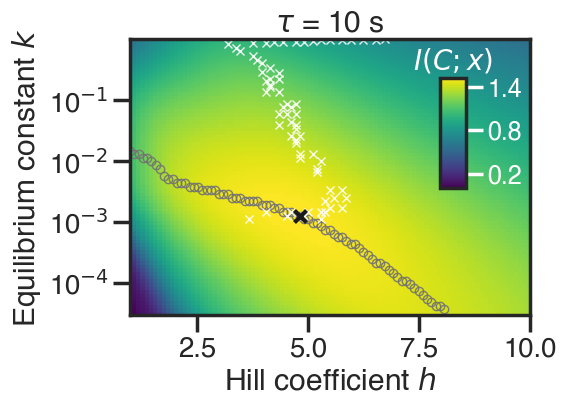

In [17]:
### FIGURE 4B: I(C;x) in the h,k-plane with optimal trajectories

###  HELPER FUNCTIONS
def get_colorbar_ticks(data):
    # Returns a list of rounded ticks at 10%, 50% and 90% of the color bar
    min_data = data.min()
    max_data = data.max()
    cbar_tick010 = np.round(min_data + (max_data - min_data) * 0.1, 1)
    cbar_tick050 = np.round(min_data + (max_data - min_data) * 0.5, 1)
    cbar_tick090 = np.round(min_data + (max_data - min_data) * 0.9, 1)
    return [cbar_tick010, cbar_tick050, cbar_tick090]

### FIGURE SETTINGS
sns.set_theme(context='poster', style='ticks', palette='deep', font='Helvetica', font_scale=0.90, color_codes=True, rc=None)
tau = 10 # which tau to plot (alternatively can hardcode tau_idx)
plot_maximum = True # if True plot max MI as 'x' in h,k plane
remove_boundary = True # Whether or not to include optimal values that lie on the h,k boundary

### IMPORT DATA
datadir = "hillmode-koff_tau10-600_h1-20_k3E-05-1E+00_kon1_koff1_n1_Sbins60_Cbins100_Ccov0.60"
loadpath = f"../Data/ModelData/{datadir}"

# Import parameters
with open(f"{loadpath}/parameters.json", "r") as file:
    parameters = json.load(file)
taus, hs, ks = parameters['taus'], parameters['hs'], parameters['ks']
tau_idx = taus.index(tau)
hs_plot = np.array(hs)
ks_plot = np.array(ks)

# Import the data
MI_all_df = pd.read_csv(f"{loadpath}/MIs_all.csv")
I_CX_test = np.reshape(MI_all_df['I_CX'],(len(hs), len(ks), len(taus)))
I_CS_test = np.reshape(MI_all_df['I_CS'],(len(hs), len(ks), len(taus)))

MI_optimalh_df  = pd.read_csv(f"{loadpath}/MIs_optimal_h.csv")
optimalh_I_CXs  = np.reshape(MI_optimalh_df['optimalh_I_CX'], (len(hs), len(taus)))
optimalh_ks_ICX = np.reshape(MI_optimalh_df['optimalh_k_ICX'], (len(hs), len(taus)))

MI_optimal_df = pd.read_csv(f"{loadpath}/MIs_optimal.csv")
Nvals = MI_optimal_df[MI_optimal_df['tau'] == taus[0]].shape[0]
optimal_hs = np.reshape(MI_optimal_df['optimal_h'], (Nvals, len(taus)))
optimal_ks = np.reshape(MI_optimal_df['optimal_k'], (Nvals, len(taus)))
optimal_I_CXs = np.reshape(MI_optimal_df['optimal_I_CX'], (Nvals, len(taus)))

# Optional: set values that are near boundary to 0 since they might not be representative
if remove_boundary:
    # First remove boundary of optimal I(C;x) per I(C;s)
    if np.any(optimal_hs[:,tau_idx] <= hs[3]):
        optimal_hs[np.where(optimal_hs[:,tau_idx] <= hs[1])[0],tau_idx] = 0     
    if np.any(optimal_ks[:,tau_idx] >= ks[-3]):
        optimal_hs[:np.where(optimal_ks[:,tau_idx] >= ks[-1])[0][-1],tau_idx] = 0
    
    # Remove boundary of optimal I(C;x) per h 
    hs_plot[np.where(optimalh_ks_ICX[:,tau_idx] <= ks[0])[0]] = 0

### PLOT FIGURE
fig, ax = plt.subplots(1,1, figsize = (6,4.5))

# Plot I(C;x) heatmap
c1 = ax.pcolor(hs, np.log10(ks), I_CX_test[:, :, tau_idx].T, cmap='viridis')

# Set logarithmic ticks
ax.tick_params(axis='both', which='major')
ax.set_yticks([0,-1,-2,-3,-4])
ax.set_yticklabels(['10$^{0}$','10$^{-1}$', '10$^{-2}$', '10$^{-3}$', '10$^{-4}$'])

# Plot the optimal I(C;x) per h 
non_zero_hs_h = np.where(hs_plot != 0)[0]
ax.plot(hs_plot[non_zero_hs_h], np.log10(optimalh_ks_ICX[non_zero_hs_h,tau_idx]), 'o', fillstyle='none', markersize=6, color='#737373', alpha=0.9, label=f'tau={taus[tau_idx]}')

# Plot the optimal I(C;x) per I(C;s) 
non_zero_hs = np.where(optimal_hs[:, tau_idx] != 0)[0]
ax.plot(optimal_hs[non_zero_hs, tau_idx], np.log10(optimal_ks[non_zero_hs, tau_idx]), 'x', markersize=6, color='w', alpha=0.9, label=f'tau={taus[tau_idx]}')

# Plot the maximum of I(C;x) as an 'x'
if plot_maximum:
    max_IC_X_idx = np.where(I_CX_test[:,:, tau_idx] == I_CX_test[:,:, tau_idx].max())
    h_at_max, k_at_max = hs_plot[max_IC_X_idx[0]], ks_plot[max_IC_X_idx[1]]
    ax.scatter(h_at_max, np.log10(k_at_max), marker='x', color='k', s=75, linewidths=3, zorder=6)

# Colorbar for I(C;x) 
cax1 = inset_axes(ax, width="6.5%", height="40%", loc='lower right',
                bbox_to_anchor=(-0.16, 0.46, 1, 1), bbox_transform=ax.transAxes, borderpad=0)
cbar1 = fig.colorbar(c1, cax=cax1)
cbar1.set_ticks(get_colorbar_ticks(I_CX_test[:, :, tau_idx]))
cbar1.ax.yaxis.set_tick_params(color='white', labelsize=18)
cbar1.ax.set_title(r'$I(C;x)$', color='white', fontsize=20)
plt.setp(plt.getp(cbar1.ax.axes, 'yticklabels'), color='white')

# Set figure labels and title
ax.set_ylabel(r'Equilibrium constant $k$')
ax.set_xlabel(r'Hill coefficient $h$')  
ax.set_title(r'$\tau$ = ' + f'{taus[tau_idx]} s')

# Final adjustments
ax.set_xlim([1,10])
plt.tight_layout()

# Save figure
plt.savefig('../Figures/SupFigure8.png', dpi=300)
